In [28]:
import sys
import os
import cv2
import random
import shutil
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
import math
import pickle
import pprint
import shutil
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import imageio.v3 as iio
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.metrics import FBetaScore
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


# # import own modules
sys.path.append("..")  # Adds higher directory to python modules path.
from scripts import features as ft
from scripts import preprocessing as pp

In [3]:
# path to csv file
#path_df = os.path.join("..", "data", "df_deepgaze2e.csv")
path_df = os.path.join("..", "data", "df_deep_sam.csv")

# get features - or recalculate
recalculate_df = False
if os.path.isfile(path_df) and not recalculate_df:
    df = pd.read_csv(path_df)
else:
    df = ft.get_features()
    df.to_csv(path_df, index=False)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=['img', 'sp_idx'])
df = df.drop(columns=[col for col in df.columns if "_obj" in col])  # drop 'object' columns

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7598 instances and 44 columns
 -> there are 44 numerical columns
 -> there are 0 categoricals columns


In [4]:
# processing
df = df[df["sp_fix_duration_ms_total"] <= 5000]
#df = df.drop(columns=['sal_first_above_0.75*max_rank', 'sal_first_above_0.9*max_rank'])

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7217 instances and 44 columns
 -> there are 44 numerical columns
 -> there are 0 categoricals columns


Correlation between dg_sal_first_fixation and sam_sal_first_fixation is 0.816
Correlation between dg_sal_first_above_0.75*max_rank and dg_sal_max is -0.802
Correlation between dg_sal_sum and sam_sal_sum is 0.851
Correlation between dg_sal_weighted_duration_sum and sam_sal_weighted_duration_sum is 0.865
Correlation between dg_sal_weighted_duration_mean and sam_sal_weighted_duration_mean is 0.887
Correlation between dg_sal_NSS and sam_sal_NSS is 0.862
Correlation between sam_sal_mean and sam_sal_NSS is 0.85


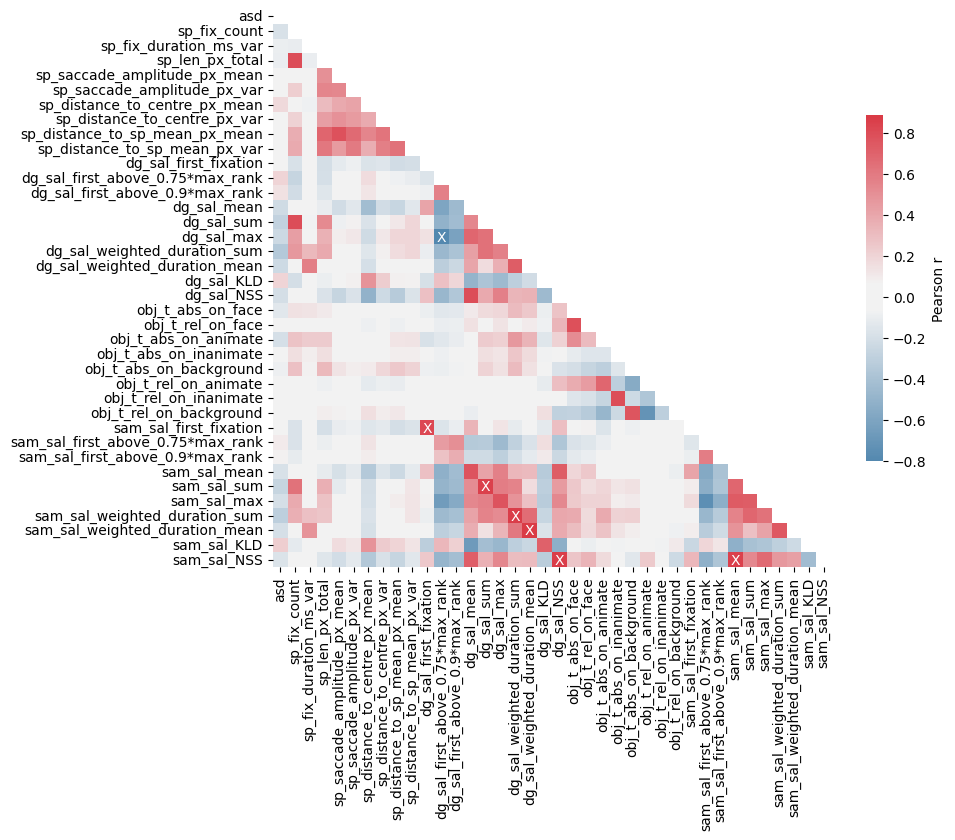

 -> dataframe has 7217 instances and 38 columns
 -> there are 38 numerical columns
 -> there are 0 categoricals columns


In [5]:
# processing
df = df.drop(
    columns=[
        "sp_fix_duration_ms_total",
        "sp_fix_duration_ms_mean",
        "obj_n_fix_face",
        "obj_n_fix_animate",
        "obj_n_fix_inanimate",
        "obj_n_fix_background",
    ]
)

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# check for correlations, again
pp.check_correlations(df[num_cols], thresh=0.8)

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

In [6]:
# prepare features and target
X = df
y = X.pop("asd")

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

train-set has '6485' samples & '37' features
test-set has '732' samples - out of '7217'
  ~ 10.14% of full dataset


In [7]:
# creating the dataframe of X_train and X_test
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

In [8]:
print(X_train_df.shape)
print(X_test_df.shape)

(6485, 37)
(732, 37)


Function to copy images (individual heatmaps) from a source into a new folder based on the 'id'

- Do it for both train and test sets

- Use 'id' since it is common between the dataframes of the train and test sets and the heatmaps in the three folders:
      - "fds_dg" (individual heatmaps with three channels: one channel is 'fix', another channel is 'dur', another channel is 'sal_dg')

In [9]:
def copy_images_by_id(df, source_folder, destination_folder):
    """
    Copies images from Individual_FixMaps folder to Train folder based on the id (index) in the X_train_df dataFrame.

    Args:
    - df : Dataframe where the functions copy images by id will be called for
    - source_folder : folder where image will be copied from
    - destination_folder : folder where images will be copied to

    Returns:
    - None
    """
 
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    asd = []
    filename = []

    # Loop through the index of the X_train_df
    for id in df.index:
        source_path = os.path.join(source_folder, f"{id}.jpg")
        destination_path = os.path.join(destination_folder, f"{id}.jpg")
        filename.append(destination_path)
        
        if 'asd' in id:
            asd.append('1')
        else: 
            asd.append('0')

        # Check if the image file exists in the "Individual_FixMaps" folder
        if os.path.exists(source_path):
        # Copy the image file to the "Train" folder
            shutil.copyfile(source_path, destination_path)
            print(f"Copied image {id}.jpg")
        else:
            print(f"Image {id}.jpg not found in the source folder.") 

### Define source folder and destination folder and apply the function "copy_images_by_id" for the train data

In [10]:
# define source folder
    
source_folder = '../data/individual_maps/fds_dg'

# define destination folder

destination_folder = '../data/CNN/Train'

train_data = copy_images_by_id(X_train_df, source_folder, destination_folder)

#train_data.to_csv(os.path.join(destination_folder, "..", 'train_data.csv'), index=False)

Copied image asd_001_00.jpg
Copied image asd_001_01.jpg
Copied image asd_001_02.jpg
Copied image asd_001_03.jpg
Copied image asd_001_04.jpg
Copied image asd_001_05.jpg
Copied image asd_001_06.jpg
Copied image asd_001_07.jpg
Copied image asd_001_08.jpg
Copied image asd_001_09.jpg
Copied image asd_001_10.jpg
Copied image asd_001_11.jpg
Copied image asd_001_12.jpg
Copied image asd_010_00.jpg
Copied image asd_010_01.jpg
Copied image asd_010_02.jpg
Copied image asd_010_03.jpg
Copied image asd_010_04.jpg
Copied image asd_010_05.jpg
Copied image asd_010_06.jpg
Copied image asd_010_07.jpg
Copied image asd_010_08.jpg
Copied image asd_010_09.jpg
Copied image asd_010_10.jpg
Copied image asd_010_11.jpg
Copied image asd_010_12.jpg
Copied image asd_100_01.jpg
Copied image asd_100_02.jpg
Copied image asd_100_03.jpg
Copied image asd_100_04.jpg
Copied image asd_100_05.jpg
Copied image asd_100_06.jpg
Copied image asd_100_07.jpg
Copied image asd_100_08.jpg
Copied image asd_100_09.jpg
Copied image asd_101

### Define source folder and destination folder and apply the function "copy_images_by_id" for the test data

In [11]:
# define source folder
    
source_folder = '../data/individual_maps/fds_dg'

# define destination folder for test 

destination_folder = '../data/CNN/Test'

test_data = copy_images_by_id(X_test_df, source_folder, destination_folder)

#test_data.to_csv(os.path.join(destination_folder, "..", 'test_data.csv'), index=False)

Copied image asd_112_01.jpg
Copied image asd_112_02.jpg
Copied image asd_112_03.jpg
Copied image asd_112_04.jpg
Copied image asd_112_05.jpg
Copied image asd_112_06.jpg
Copied image asd_112_07.jpg
Copied image asd_112_08.jpg
Copied image asd_112_09.jpg
Copied image asd_112_10.jpg
Copied image asd_113_00.jpg
Copied image asd_113_02.jpg
Copied image asd_113_03.jpg
Copied image asd_113_04.jpg
Copied image asd_113_05.jpg
Copied image asd_113_06.jpg
Copied image asd_113_07.jpg
Copied image asd_113_08.jpg
Copied image asd_113_09.jpg
Copied image asd_113_10.jpg
Copied image asd_120_00.jpg
Copied image asd_120_01.jpg
Copied image asd_120_02.jpg
Copied image asd_120_03.jpg
Copied image asd_120_04.jpg
Copied image asd_120_05.jpg
Copied image asd_120_06.jpg
Copied image asd_120_07.jpg
Copied image asd_120_08.jpg
Copied image asd_120_09.jpg
Copied image asd_120_10.jpg
Copied image asd_120_11.jpg
Copied image asd_135_00.jpg
Copied image asd_135_01.jpg
Copied image asd_135_02.jpg
Copied image asd_135

### Scaling down (256 x 256) the images (heatmaps)
#### - Define a function ('scale_images_from_dir') that gets images from source directories and place the resized images in new directories 

In [12]:
# Define the directory paths for train and test data

train_dir = '../data/CNN/Train'
test_dir = '../data/CNN/Test'
train_resize_dir = "../data/CNN/Train_resize256"
test_resize_dir = "../data/CNN/Test_resize256"

# define the function for resizing images from train and test
def scale_images_from_dir(directory, resize_directory):
    images = []
    labels = []
    print("Directory:", directory)

    # Iterate over files directly in the directory
    for filename in os.listdir(directory):
        print("Filename:", filename)

        # Load the image
        img_path = os.path.join(directory, filename)
        print("Image path:", img_path)
        img = cv2.imread(img_path)
        
        # If the image is not None (i.e., it was successfully loaded)
        if img is not None:
            # Preprocess the image (e.g., resize, normalize)
            resized_image = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)

            # save the resized image to the resized directory
            save_path = resize_directory  # Since there are no class subdirectories
            print("Save path:", save_path)

            if not os.path.exists(save_path):
                os.makedirs(save_path)

            cv2.imwrite(os.path.join(save_path, filename), resized_image)

            # Append the scaled image and its label to the lists
            images.append(img)
            labels.append(filename)  # Assuming filename represents the class

    return images, labels

#### Apply the function 'scale_images_from_dir'

In [13]:
# Apply the function to images and labels from train and test directories

train_images, train_labels = scale_images_from_dir(train_dir,train_resize_dir)
test_images, test_labels = scale_images_from_dir(test_dir, test_resize_dir)

# Print the number of the scaled images and labels

print("Number of train images:", len(train_images))
print("Number of train labels:", len(train_labels))
print("Number of test images:", len(test_images))
print("Number of test labels:", len(test_labels))

Directory: /Users/marianosantoro/Desktop/neuefische/Capstone_project/data/CNN/Train
Filename: asd_010_07.jpg
Image path: /Users/marianosantoro/Desktop/neuefische/Capstone_project/data/CNN/Train/asd_010_07.jpg
Save path: /Users/marianosantoro/Desktop/neuefische/Capstone_project/data/CNN/Train_resize256
Filename: td_182_00.jpg
Image path: /Users/marianosantoro/Desktop/neuefische/Capstone_project/data/CNN/Train/td_182_00.jpg
Save path: /Users/marianosantoro/Desktop/neuefische/Capstone_project/data/CNN/Train_resize256
Filename: asd_192_04.jpg
Image path: /Users/marianosantoro/Desktop/neuefische/Capstone_project/data/CNN/Train/asd_192_04.jpg
Save path: /Users/marianosantoro/Desktop/neuefische/Capstone_project/data/CNN/Train_resize256
Filename: asd_225_10.jpg
Image path: /Users/marianosantoro/Desktop/neuefische/Capstone_project/data/CNN/Train/asd_225_10.jpg
Save path: /Users/marianosantoro/Desktop/neuefische/Capstone_project/data/CNN/Train_resize256
Filename: asd_092_10.jpg
Image path: /User

### Load and preprocessing images 

#### - Function called "load_and_preprocess_images_and_labels": adding img.astype('float32') / 255.0, we ensure that the loaded images are converted to float32 format and normalized to the range between 0 and 1

In [14]:
# Set paths and parameters
train_resize_dir = "../data/CNN/Train_resize256"
test_resize_dir = "../data/CNN/Test_resize256"


# Function to load images and labels
def load_and_preprocess_images_and_labels(directory):
    images = []
    labels = []
    print("Directory:", directory)
    # Iterate over files directly in the directory
    for filename in os.listdir(directory):
         print("Filename:", filename)
       # Load the image
         img_path = os.path.join(directory, filename)
         print("Image path:", img_path)
         img = cv2.imread(img_path)
       # Convert image to float32 and normalize its values to range [0, 1]
         img = img.astype('float32') / 255.0
         images.append(img)
         labels.append(filename)
    return np.array(images), np.array(labels)

### Apply the function on both train and test sets

In [15]:
# For training data
train_images, train_labels = load_and_preprocess_images_and_labels(train_resize_dir)

# For test data
test_images, test_labels = load_and_preprocess_images_and_labels(test_resize_dir)

Directory: /Users/marianosantoro/Desktop/neuefische/Capstone_project/data/CNN/Train_resize256
Filename: asd_010_07.jpg
Image path: /Users/marianosantoro/Desktop/neuefische/Capstone_project/data/CNN/Train_resize256/asd_010_07.jpg
Filename: td_182_00.jpg
Image path: /Users/marianosantoro/Desktop/neuefische/Capstone_project/data/CNN/Train_resize256/td_182_00.jpg
Filename: asd_192_04.jpg
Image path: /Users/marianosantoro/Desktop/neuefische/Capstone_project/data/CNN/Train_resize256/asd_192_04.jpg
Filename: asd_225_10.jpg
Image path: /Users/marianosantoro/Desktop/neuefische/Capstone_project/data/CNN/Train_resize256/asd_225_10.jpg
Filename: asd_092_10.jpg
Image path: /Users/marianosantoro/Desktop/neuefische/Capstone_project/data/CNN/Train_resize256/asd_092_10.jpg
Filename: td_185_09.jpg
Image path: /Users/marianosantoro/Desktop/neuefische/Capstone_project/data/CNN/Train_resize256/td_185_09.jpg
Filename: asd_092_04.jpg
Image path: /Users/marianosantoro/Desktop/neuefische/Capstone_project/data/

#### Check which data types are ther images and the labels

In [16]:
print(train_images.dtype)
print(train_labels.dtype)
print(test_images.dtype)
print(test_labels.dtype)

float32
<U14
float32
<U14


#### - Get the classes from the train set with a for loop 
#### - Check if they have been extracted (by printing them)

In [17]:
# Extract class information from the train set

classes = [label.split('_')[0] for label in train_labels]

print(classes)

['asd', 'td', 'asd', 'asd', 'asd', 'td', 'asd', 'td', 'td', 'asd', 'asd', 'asd', 'td', 'td', 'asd', 'td', 'td', 'asd', 'asd', 'td', 'td', 'asd', 'asd', 'asd', 'td', 'td', 'asd', 'td', 'td', 'td', 'td', 'asd', 'asd', 'asd', 'td', 'td', 'asd', 'asd', 'asd', 'asd', 'td', 'td', 'td', 'td', 'asd', 'asd', 'asd', 'td', 'td', 'asd', 'td', 'asd', 'td', 'td', 'td', 'asd', 'td', 'asd', 'td', 'td', 'asd', 'td', 'td', 'asd', 'asd', 'td', 'asd', 'asd', 'td', 'td', 'asd', 'asd', 'asd', 'asd', 'td', 'asd', 'td', 'td', 'asd', 'td', 'asd', 'td', 'asd', 'td', 'td', 'td', 'asd', 'asd', 'asd', 'td', 'td', 'asd', 'asd', 'td', 'asd', 'td', 'td', 'asd', 'td', 'asd', 'asd', 'td', 'td', 'td', 'asd', 'asd', 'asd', 'td', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'td', 'td', 'asd', 'td', 'asd', 'asd', 'td', 'asd', 'asd', 'td', 'td', 'td', 'td', 'asd', 'td', 'td', 'td', 'td', 'asd', 'asd', 'td', 'asd', 'asd', 'td', 'td', 'td', 'asd', 'td', 'asd', 'td', 'asd', 'td', 'td', 'asd', 'asd', 'td', 'asd', 'asd', 'td', 'asd

#### - Get the classes from the test set with a for loop 
#### - Check if they have been extracted (by printing them)

In [18]:
# Extract class information from the test set

classes_2 = [label.split('_')[0] for label in test_labels]

print(classes_2)

['asd', 'asd', 'asd', 'asd', 'td', 'asd', 'asd', 'td', 'td', 'td', 'td', 'asd', 'td', 'asd', 'td', 'td', 'td', 'asd', 'td', 'asd', 'asd', 'asd', 'asd', 'td', 'asd', 'asd', 'td', 'asd', 'asd', 'asd', 'td', 'asd', 'td', 'td', 'td', 'td', 'asd', 'td', 'asd', 'td', 'td', 'td', 'td', 'td', 'td', 'asd', 'asd', 'td', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'td', 'td', 'asd', 'td', 'td', 'td', 'td', 'td', 'td', 'asd', 'asd', 'td', 'td', 'td', 'td', 'td', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'td', 'td', 'asd', 'asd', 'asd', 'asd', 'asd', 'td', 'td', 'td', 'td', 'td', 'asd', 'asd', 'td', 'td', 'td', 'td', 'td', 'asd', 'td', 'td', 'asd', 'asd', 'asd', 'asd', 'asd', 'td', 'td', 'asd', 'asd', 'asd', 'asd', 'td', 'td', 'asd', 'asd', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'asd', 'asd', 'td'

In [19]:
# Convert labels from string to integers for the train set

encoder = LabelEncoder()

# Encode classes into binary labels

binary_labels = encoder.fit_transform(classes)

In [20]:
# Check the number of unique classes in the train set

num_classes = len(encoder.classes_)
print("Number of unique classes:", num_classes) 

# Check the encoded labels

print("Encoded labels:", binary_labels)

Number of unique classes: 2
Encoded labels: [0 1 0 ... 1 0 1]


#### For the train set:
#### - Check data types of the images
#### - Check the labels of the images 
#### - Check the data range for both images and labels

In [9]:
# Check data types

print("Data types of Train Images:", train_images.dtype, "Train Labels:", binary_labels.dtype)

# Check shapes

print("Shapes of Train Images:", train_images.shape, "Train Labels:", binary_labels.shape)

# Check data range

print("Data range of Train Images: min =", np.min(train_images), "max =", np.max(train_images))
print("Data range of Train labels: min =", np.min(binary_labels), "max =", np.max(binary_labels))

Data types of Train Images: float32 Train Labels: int64
Shapes of Train Images: (6485, 256, 256, 3) Train Labels: (6485,)
Data range of Train Images: min = 0.0 max = 0.99215686
Data range of Train labels: min = 0 max = 1


In [21]:
# Convert labels from string to integers for the test set
# Encode classes into binary labels

encoder = LabelEncoder()
binary_labels_2 = encoder.fit_transform(classes_2) 

In [22]:
# Check the number of unique classes
num_classes_2 = len(encoder.classes_)
print("Number of unique classes:", num_classes_2) 

# Check the encoded labels
print("Encoded labels:", binary_labels_2)

Number of unique classes: 2
Encoded labels: [0 0 0 0 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0
 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0
 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1
 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1
 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1
 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1
 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0
 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1

#### For the test set:
#### - Check data types of the images
#### - Check the labels of the images 
#### - Check the data range for both images and labels

In [12]:
# Check data types
print("Data types of Test Images:", test_images.dtype, "Test Labels:", binary_labels_2.dtype)

# Check shapes
print("Shapes of Test Images:", test_images.shape, "Test Labels:", binary_labels_2.shape)

# Check data range
print("Data range of Test Images: min =", np.min(test_images), "max =", np.max(test_images))
print("Data range of Test labels: min =", np.min(binary_labels_2), "max =", np.max(binary_labels_2))

Data types of Test Images: float32 Test Labels: int64
Shapes of Test Images: (732, 256, 256, 3) Test Labels: (732,)
Data range of Test Images: min = 0.0 max = 0.8352941
Data range of Test labels: min = 0 max = 1


#### - Function to define the evaluation metrics for the business problem
#### - Fbeta_score weighted more on recall than precision, then setting with beta = 2

In [29]:
def fbeta(y_true, y_pred, beta=2):
    # Ensure y_true and y_pred are of the same shape
    y_true = tf.cast(tf.reshape(y_true, (-1,)), tf.float32)
    y_pred = tf.cast(tf.reshape(y_pred, (-1,)), tf.float32)
    
    # Convert predicted probabilities to binary predictions
    y_pred_binary = tf.cast(tf.greater_equal(y_pred, 0.5), tf.float32)
    
    # Calculate true positives, false positives, and false negatives
    true_positives = tf.reduce_sum(y_true * y_pred_binary)
    false_positives = tf.reduce_sum((1 - y_true) * y_pred_binary)
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred_binary))
    
    # Calculate precision, recall, and F-beta score
    precision = true_positives / (true_positives + false_positives + tf.keras.backend.epsilon())
    recall = true_positives / (true_positives + false_negatives + tf.keras.backend.epsilon())
    fbeta_score = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + tf.keras.backend.epsilon())
    
    return fbeta_score

### - VGG like "Model" architecture with no finetuning work
### - No dropout layers
### - The activation function used at the output layer is 'softmax' 
### - No learning rate added to the 'Adam' optimizer

In [24]:
K.clear_session() # clear the cache of model parameters

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='softmax')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[fbeta])

# Print model summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,086,913 (49.92 MB)

 Trainable params: 13,086,913 (49.92 MB)

 Non-trainable params: 0 (0.00 B)

### Training 'Model' with the following hyperparameters:
###        - Epochs number = 10
###        - Batch size = 32

In [115]:
fbeta_32_full = model.fit(train_images, binary_labels, batch_size=32, epochs=10,validation_split=0.3)

Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 52s 354ms/step - fbeta: 0.8314 - loss: 0.6904 - val_fbeta: 0.8330 - val_loss: 0.6863
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 49s 343ms/step - fbeta: 0.8330 - loss: 0.6517 - val_fbeta: 0.8330 - val_loss: 0.6466
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 49s 343ms/step - fbeta: 0.8293 - loss: 0.6294 - val_fbeta: 0.8330 - val_loss: 0.6489
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 49s 343ms/step - fbeta: 0.8205 - loss: 0.6196 - val_fbeta: 0.8330 - val_loss: 0.6403
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 49s 343ms/step - fbeta: 0.8234 - loss: 0.6181 - val_fbeta: 0.8330 - val_loss: 0.6468
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 49s 343ms/step - fbeta: 0.8262 - loss: 0.6161 - val_fbeta: 0.8330 - val_loss: 0.6360
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 49s 344ms/step - fbeta: 0.8262 - loss: 0.6138 - val_fbeta: 0.8330 - val_loss: 0.6384
Epoch 8/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 49s 345ms/step - fbeta: 0.8297 - loss: 0.6096 - val_fbeta: 0.8330 - val_loss: 0.6436


#### Plotting the history of the fbetascore for the training and the validation set

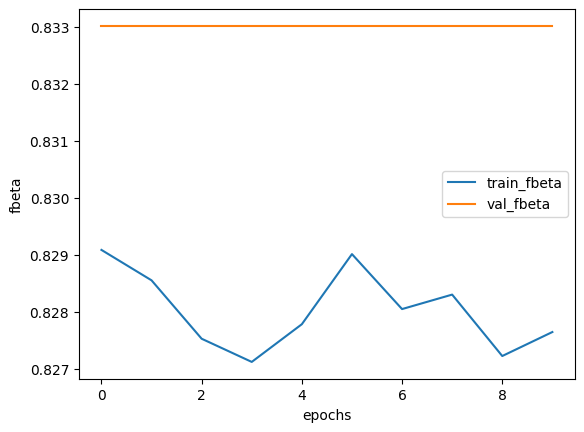

In [117]:
plt.plot(fbeta_32_full.history['fbeta'],label='train_fbeta')
plt.plot(fbeta_32_full.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('fbeta')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

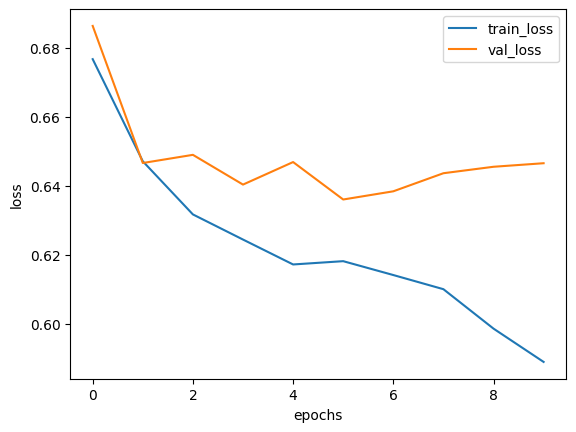

In [118]:
plt.plot(fbeta_32_full.history['loss'],label='train_loss')
plt.plot(fbeta_32_full.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model' with the following hyperparameters:
###       - Epoch number = 10
###       - Batch size = 64

In [119]:
K.clear_session() # clear the cache of model parameters

fbeta_64_full = model.fit(train_images, binary_labels, batch_size=64, epochs=10,validation_split=0.3)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 49s 674ms/step - fbeta: 0.8392 - loss: 0.5571 - val_fbeta: 0.8340 - val_loss: 0.6827
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 46s 653ms/step - fbeta: 0.8305 - loss: 0.5218 - val_fbeta: 0.8340 - val_loss: 0.7194
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 46s 652ms/step - fbeta: 0.8302 - loss: 0.5024 - val_fbeta: 0.8340 - val_loss: 0.7893
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 46s 655ms/step - fbeta: 0.8332 - loss: 0.4509 - val_fbeta: 0.8340 - val_loss: 0.8111
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 46s 653ms/step - fbeta: 0.8303 - loss: 0.3664 - val_fbeta: 0.8340 - val_loss: 0.8959
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 47s 656ms/step - fbeta: 0.8311 - loss: 0.3067 - val_fbeta: 0.8340 - val_loss: 1.0744
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 47s 657ms/step - fbeta: 0.8315 - loss: 0.2374 - val_fbeta: 0.8340 - val_loss: 1.3382
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 47s 657ms/step - fbeta: 0.8302 - loss: 0.1630 - val_fbeta: 0.8340 - val_loss: 1.6847
Epoch 9/10
71/71

### Plotting the history of the fbetascore for the training and the validation set

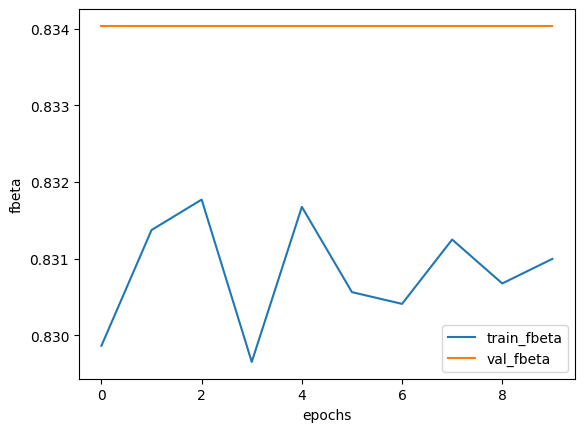

In [120]:
plt.plot(fbeta_64_full.history['fbeta'],label='train_fbeta')
plt.plot(fbeta_64_full.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('fbeta')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

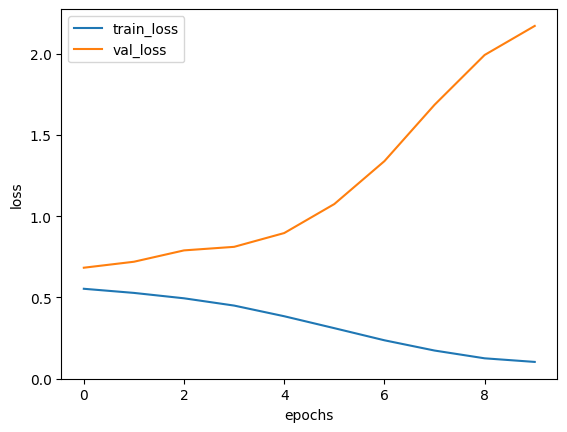

In [121]:
plt.plot(fbeta_64_full.history['loss'],label='train_loss')
plt.plot(fbeta_64_full.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model' with the following hyperparameters:
###       - Epochs number = 10
###       - Batch size = 128

In [122]:
K.clear_session() # clear the cache of model parameters

fbeta_128_full = model.fit(train_images, binary_labels, batch_size=128, epochs=10,validation_split=0.3)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - fbeta: 0.8338 - loss: 0.0583 - val_fbeta: 0.8352 - val_loss: 2.4187
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - fbeta: 0.8356 - loss: 0.0435 - val_fbeta: 0.8352 - val_loss: 2.8876
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - fbeta: 0.8273 - loss: 0.0338 - val_fbeta: 0.8352 - val_loss: 3.1903
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - fbeta: 0.8329 - loss: 0.0262 - val_fbeta: 0.8352 - val_loss: 3.4149
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - fbeta: 0.8338 - loss: 0.0221 - val_fbeta: 0.8352 - val_loss: 3.7122
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - fbeta: 0.8374 - loss: 0.0352 - val_fbeta: 0.8352 - val_loss: 3.5835
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - fbeta: 0.8298 - loss: 0.0493 - val_fbeta: 0.8352 - val_loss: 3.5384
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - fbeta: 0.8331 - loss: 0.0257 - val_fbeta: 0.8352 - val_loss: 3.7585
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 45

### Plotting the history of the fbetascore for the training and the validation set

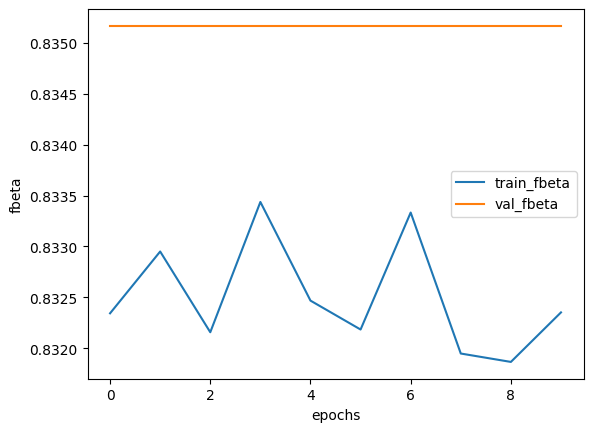

In [123]:
plt.plot(fbeta_128_full.history['fbeta'],label='train_fbeta')
plt.plot(fbeta_128_full.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('fbeta')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

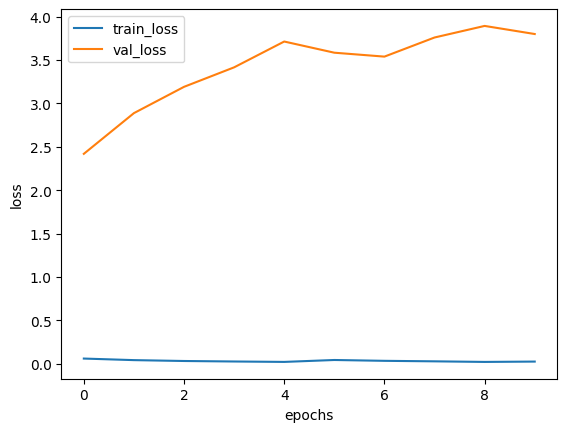

In [124]:
plt.plot(fbeta_128_full.history['loss'],label='train_loss')
plt.plot(fbeta_128_full.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### - "Model2" architecture has dropout layers after each convolutional layers set at 0.25 and one dropout layer before the output (Dense) layer set at 0.5 
##### (0.25 and 0.5 are the probabilities of dropping neurons or features in dropout layers)
### - The activation function at the output layers is 'sigmoid'

In [55]:
K.clear_session() # clear the cache of model parameters

# Define the number of classes
# For binary classification, there's only one output neuron
#num_classes=1

# Define the CNN model, this time with dropout layers to prevent overfitting

model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # dropout layer after the first convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # dropout layer after the second convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # dropout layer after the third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # dropout layer after the fourth convolutional layer
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # dropout layer before the output layer
    Dense(1, activation='sigmoid')  # Change activation function to 'sigmoid'
])

# Compile the model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=[fbeta])

model2.summary()

/Users/marianosantoro/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,086,913 (49.92 MB)

 Trainable params: 13,086,913 (49.92 MB)

 Non-trainable params: 0 (0.00 B)

### Training 'Model2' with the following hyperparameters:
### - Epoch number = 10
### - Batch size = 32

In [27]:
K.clear_session() # clear the cache of model parameters

fbetamodel2_32 = model2.fit(train_images, binary_labels, batch_size=32, epochs=10,validation_split=0.3)

Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 50s 331ms/step - fbeta: 0.5565 - loss: 0.6659 - val_fbeta: 0.6805 - val_loss: 0.6395
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 52s 365ms/step - fbeta: 0.6442 - loss: 0.6507 - val_fbeta: 0.6243 - val_loss: 0.6350
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 51s 361ms/step - fbeta: 0.6611 - loss: 0.6361 - val_fbeta: 0.7879 - val_loss: 0.6572
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 51s 359ms/step - fbeta: 0.6418 - loss: 0.6346 - val_fbeta: 0.7528 - val_loss: 0.6377
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 52s 363ms/step - fbeta: 0.7032 - loss: 0.6179 - val_fbeta: 0.7269 - val_loss: 0.6324
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 51s 361ms/step - fbeta: 0.6734 - loss: 0.6169 - val_fbeta: 0.6045 - val_loss: 0.6353
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 51s 360ms/step - fbeta: 0.7003 - loss: 0.6093 - val_fbeta: 0.5571 - val_loss: 0.6407
Epoch 8/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 51s 359ms/step - fbeta: 0.6775 - loss: 0.6086 - val_fbeta: 0.6945 - val_loss: 0.6349


### Prediction with the 'Model2' run on the images of the test set and hyperparameters used in the training in the previous cell

In [63]:
model2.predict(test_images)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step


array([[0.4845486 , 0.50762665],
       [0.5290722 , 0.46754792],
       [0.6055277 , 0.4082596 ],
       ...,
       [0.56017745, 0.4428685 ],
       [0.6054942 , 0.4082987 ],
       [0.5911167 , 0.4164853 ]], dtype=float32)

### Plotting the history of the fbetascore for the training and the validation set

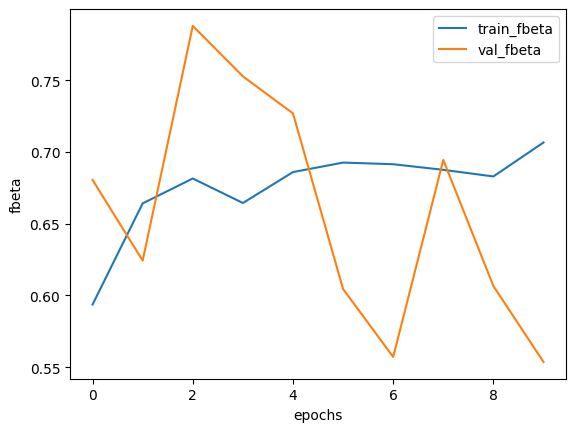

In [28]:
plt.plot(fbetamodel2_32.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel2_32.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('fbeta')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

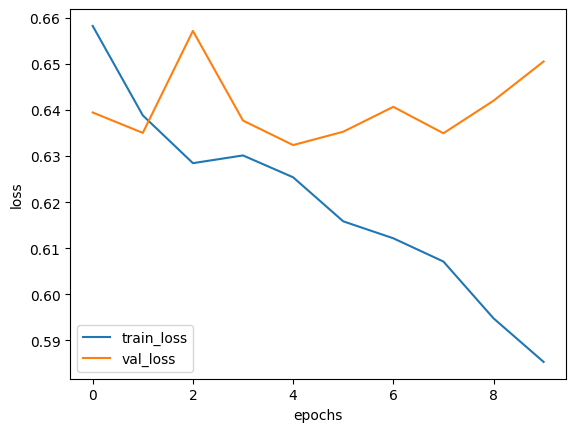

In [29]:
plt.plot(fbetamodel2_32.history['loss'],label='train_loss')
plt.plot(fbetamodel2_32.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model2' with the following hyperparameters:
### - Epochs number = 10
### - Batch size = 64

In [30]:
K.clear_session() # clear the cache of model parameters

fbetamodel2_64 = model2.fit(train_images, binary_labels, batch_size=64, epochs=10,validation_split=0.3)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 48s 670ms/step - fbeta: 0.7277 - loss: 0.5478 - val_fbeta: 0.6255 - val_loss: 0.6411
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 51s 718ms/step - fbeta: 0.7384 - loss: 0.5243 - val_fbeta: 0.5393 - val_loss: 0.6648
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 51s 719ms/step - fbeta: 0.7329 - loss: 0.5188 - val_fbeta: 0.5704 - val_loss: 0.6689
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 54s 757ms/step - fbeta: 0.7321 - loss: 0.5006 - val_fbeta: 0.5668 - val_loss: 0.6756
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 51s 725ms/step - fbeta: 0.7580 - loss: 0.4761 - val_fbeta: 0.6160 - val_loss: 0.7019
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 51s 718ms/step - fbeta: 0.7791 - loss: 0.4463 - val_fbeta: 0.5552 - val_loss: 0.7139
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 51s 717ms/step - fbeta: 0.7854 - loss: 0.4075 - val_fbeta: 0.6411 - val_loss: 0.7162
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 51s 720ms/step - fbeta: 0.8165 - loss: 0.3726 - val_fbeta: 0.5757 - val_loss: 0.7879
Epoch 9/10
71/71

### Plotting the history of the fbetascore for the training and the validation set

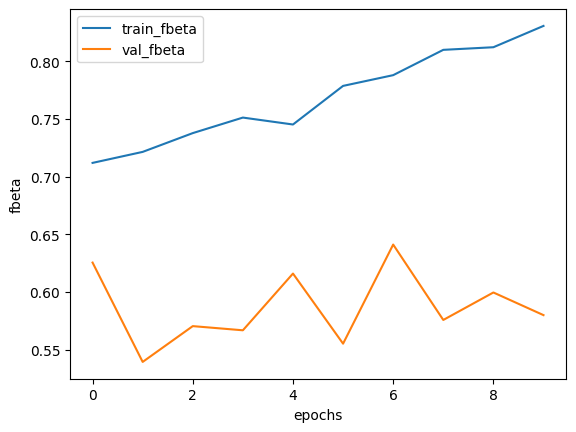

In [31]:
plt.plot(fbetamodel2_64.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel2_64.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('fbeta')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

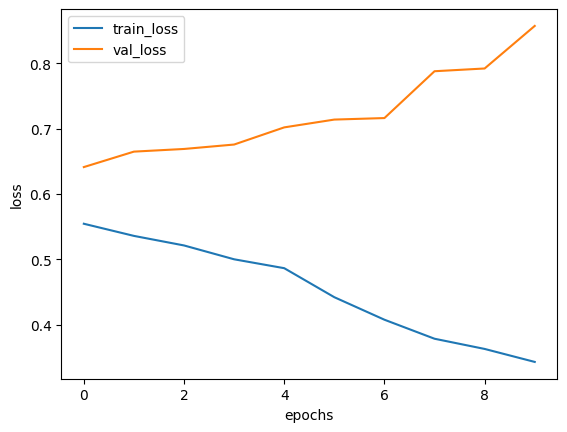

In [32]:
plt.plot(fbetamodel2_64.history['loss'],label='train_loss')
plt.plot(fbetamodel2_64.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model2' with the following hyperparameters:
### - Epoch number = 20
### - Batch size = 128

In [33]:
K.clear_session() # clear the cache of model parameters

fbetamodel2_128 = model2.fit(train_images, binary_labels, batch_size=128, epochs=10,validation_split=0.3)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - fbeta: 0.8580 - loss: 0.2860 - val_fbeta: 0.5843 - val_loss: 0.9434
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - fbeta: 0.8726 - loss: 0.2512 - val_fbeta: 0.6253 - val_loss: 1.0113
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - fbeta: 0.8858 - loss: 0.2414 - val_fbeta: 0.5831 - val_loss: 1.0465
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - fbeta: 0.8939 - loss: 0.2165 - val_fbeta: 0.6399 - val_loss: 1.1117
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - fbeta: 0.8947 - loss: 0.2089 - val_fbeta: 0.6239 - val_loss: 1.1256
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - fbeta: 0.9163 - loss: 0.1829 - val_fbeta: 0.5730 - val_loss: 1.1708
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - fbeta: 0.9165 - loss: 0.1775 - val_fbeta: 0.5638 - val_loss: 1.2456
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - fbeta: 0.9219 - loss: 0.1705 - val_fbeta: 0.5832 - val_loss: 1.1920
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 53

### Plotting the history of the fbetascore for the training and the validation set

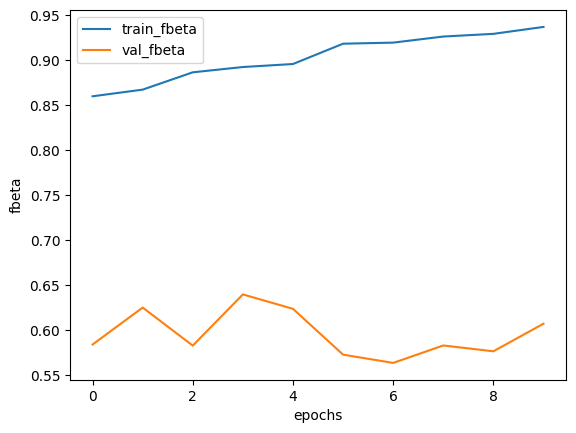

In [34]:
plt.plot(fbetamodel2_128.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel2_128.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('fbeta')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

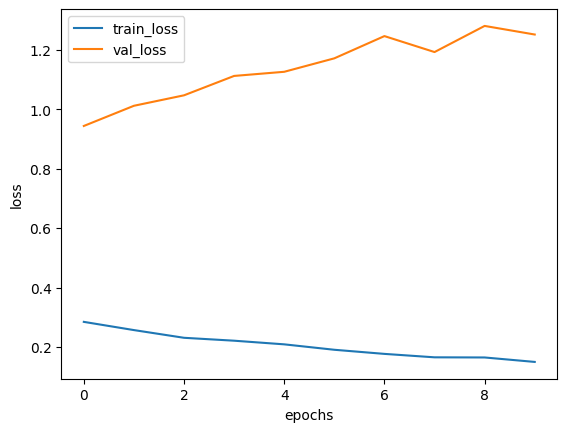

In [35]:
plt.plot(fbetamodel2_128.history['loss'],label='train_loss')
plt.plot(fbetamodel2_128.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model2' with the following hyperparameters:
### - Epochs number = 20
### - Batch size = 256

In [37]:
K.clear_session() # clear the cache of model parameters

fbetamodel2_256 = model2.fit(train_images, binary_labels, batch_size=256, epochs=10,validation_split=0.3)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - fbeta: 0.5370 - loss: 0.6888 - val_fbeta: 0.2786 - val_loss: 0.6746
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - fbeta: 0.6372 - loss: 0.6531 - val_fbeta: 0.3623 - val_loss: 0.6672
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - fbeta: 0.6733 - loss: 0.6264 - val_fbeta: 0.5364 - val_loss: 0.6332
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - fbeta: 0.7267 - loss: 0.6042 - val_fbeta: 0.4589 - val_loss: 0.6424
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - fbeta: 0.7136 - loss: 0.6032 - val_fbeta: 0.4603 - val_loss: 0.6430
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - fbeta: 0.7283 - loss: 0.5932 - val_fbeta: 0.6364 - val_loss: 0.6218
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - fbeta: 0.7129 - loss: 0.5914 - val_fbeta: 0.5761 - val_loss: 0.6279
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - fbeta: 0.7221 - loss: 0.5770 - val_fbeta: 0.6045 - val_loss: 0.6264
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 58

### Plotting the history of the fbetascore for the training and the validation set

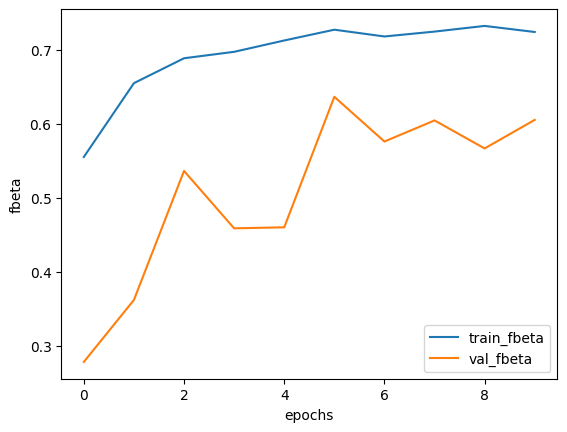

In [38]:
plt.plot(fbetamodel2_256.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel2_256.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('fbeta')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

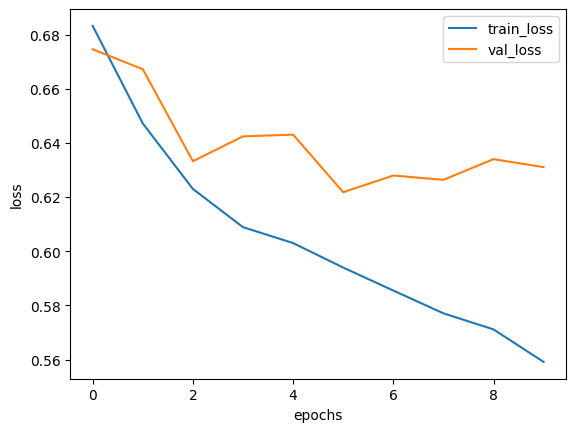

In [40]:
plt.plot(fbetamodel2_256.history['loss'],label='train_loss')
plt.plot(fbetamodel2_256.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model2' with the following hyperparameters:
### - Epoch number = 20
### - Batch size = 512

In [21]:
K.clear_session() # clear the cache of model parameters

fbetamodel2_512 = model2.fit(train_images, binary_labels, batch_size=512, epochs=10,validation_split=0.3)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 69s 7s/step - fbeta: 0.1957 - loss: 0.6931 - val_fbeta: 0.0000e+00 - val_loss: 0.6932
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step - fbeta: 0.3631 - loss: 0.6933 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - fbeta: 0.8347 - loss: 0.6932 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - fbeta: 0.7634 - loss: 0.6932 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - fbeta: 0.5961 - loss: 0.6932 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 66s 7s/step - fbeta: 0.4658 - loss: 0.6932 - val_fbeta: 0.0000e+00 - val_loss: 0.6932
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 70s 8s/step - fbeta: 0.3324 - loss: 0.6931 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 67s 7s/step - fbeta: 0.6548 - loss: 0.6932 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 67s 7s/step 

### Plotting the history of the fbetascore for the training and the validation set

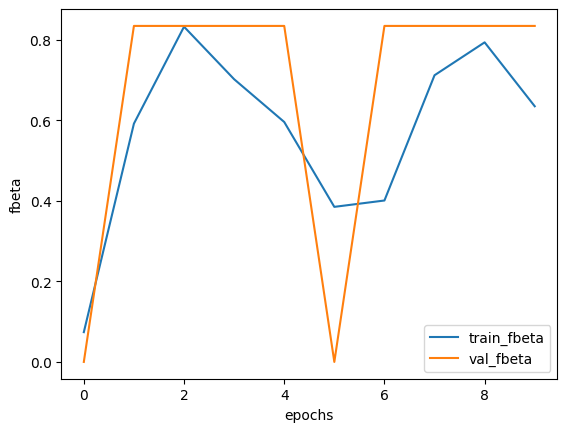

In [22]:
plt.plot(fbetamodel2_512.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel2_512.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('fbeta')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

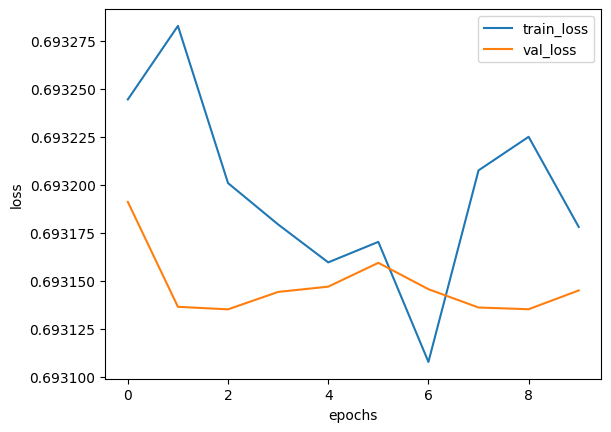

In [23]:
plt.plot(fbetamodel2_512.history['loss'],label='train_loss')
plt.plot(fbetamodel2_512.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model2' with the following hyperparameters:
### - Epochs number = 20
### - Batch size = 32

In [25]:
K.clear_session() # clear the cache of model parameters

fbetamodel2_32_20 = model2.fit(train_images, binary_labels, batch_size=32, epochs=20,validation_split=0.3)

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 49s 333ms/step - fbeta: 0.6390 - loss: 0.6717 - val_fbeta: 0.6857 - val_loss: 0.6374
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 52s 364ms/step - fbeta: 0.6390 - loss: 0.6427 - val_fbeta: 0.4727 - val_loss: 0.6480
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 51s 362ms/step - fbeta: 0.6696 - loss: 0.6337 - val_fbeta: 0.6551 - val_loss: 0.6309
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 51s 361ms/step - fbeta: 0.6712 - loss: 0.6284 - val_fbeta: 0.6261 - val_loss: 0.6314
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 52s 363ms/step - fbeta: 0.7020 - loss: 0.6158 - val_fbeta: 0.5915 - val_loss: 0.6380
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 51s 362ms/step - fbeta: 0.6987 - loss: 0.6115 - val_fbeta: 0.4825 - val_loss: 0.6481
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 51s 362ms/step - fbeta: 0.6856 - loss: 0.6152 - val_fbeta: 0.4570 - val_loss: 0.6571
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 51s 362ms/step - fbeta: 0.6934 - loss: 0.5975 - val_fbeta: 0.6194 - val_loss: 0.6367


### Plotting the history of the fbetascore for the training and the validation set

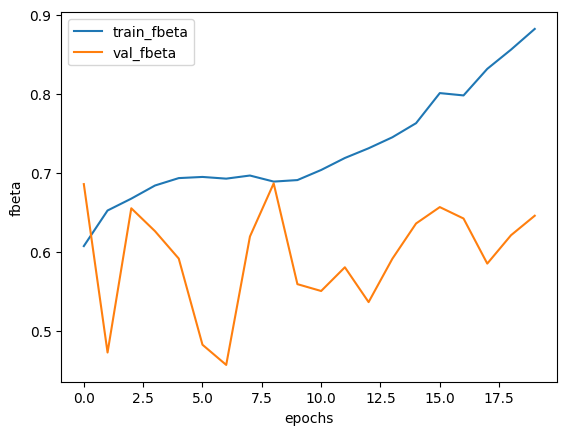

In [26]:
plt.plot(fbetamodel2_32_20.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel2_32_20.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('fbeta')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

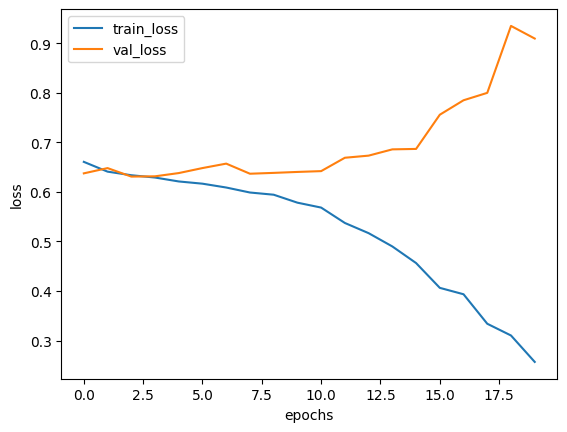

In [27]:
plt.plot(fbetamodel2_32_20.history['loss'],label='train_loss')
plt.plot(fbetamodel2_32_20.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model2' with the following hyperparameters:
### - Epoch number = 20
### - Batch size = 64

In [29]:
K.clear_session() # clear the cache of model parameters

fbetamodel2_64_20 = model2.fit(train_images, binary_labels, batch_size=64, epochs=20,validation_split=0.3)

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 49s 670ms/step - fbeta: 0.6356 - loss: 0.6666 - val_fbeta: 0.5764 - val_loss: 0.6343
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 51s 715ms/step - fbeta: 0.6668 - loss: 0.6392 - val_fbeta: 0.6299 - val_loss: 0.6309
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 51s 717ms/step - fbeta: 0.6915 - loss: 0.6362 - val_fbeta: 0.5964 - val_loss: 0.6356
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 51s 714ms/step - fbeta: 0.6917 - loss: 0.6231 - val_fbeta: 0.6292 - val_loss: 0.6345
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 51s 715ms/step - fbeta: 0.7085 - loss: 0.6122 - val_fbeta: 0.6703 - val_loss: 0.6324
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 51s 717ms/step - fbeta: 0.7046 - loss: 0.6092 - val_fbeta: 0.6732 - val_loss: 0.6276
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 51s 720ms/step - fbeta: 0.6898 - loss: 0.6147 - val_fbeta: 0.5682 - val_loss: 0.6376
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 51s 712ms/step - fbeta: 0.7190 - loss: 0.6023 - val_fbeta: 0.6415 - val_loss: 0.6314
Epoch 9/20
71/71

### Plotting the history of the fbetascore for the training and the validation set

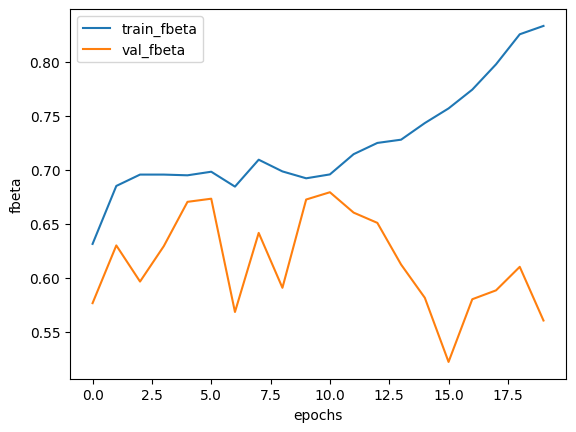

In [30]:
plt.plot(fbetamodel2_64_20.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel2_64_20.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('fbeta')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

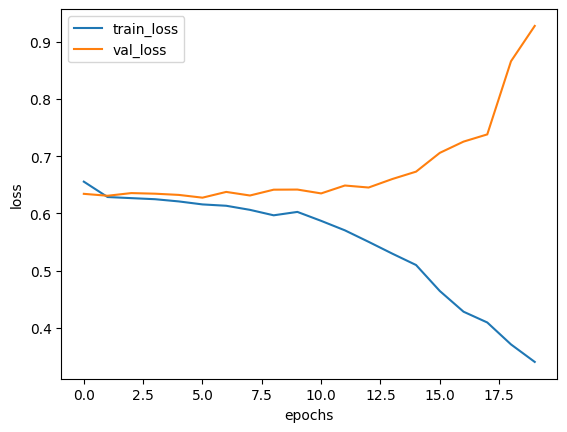

In [31]:
plt.plot(fbetamodel2_64_20.history['loss'],label='train_loss')
plt.plot(fbetamodel2_64_20.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model2' with the following hyperparameters:
### - Epochs number = 20
### - Batch size = 128

In [33]:
K.clear_session() # clear the cache of model parameters

fbetamodel2_128_20 = model2.fit(train_images, binary_labels, batch_size=128, epochs=20,validation_split=0.3)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - fbeta: 0.5903 - loss: 0.6835 - val_fbeta: 0.0967 - val_loss: 0.6864
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - fbeta: 0.6433 - loss: 0.6430 - val_fbeta: 0.0491 - val_loss: 0.7317
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - fbeta: 0.6265 - loss: 0.6398 - val_fbeta: 0.5537 - val_loss: 0.6342
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - fbeta: 0.7240 - loss: 0.6130 - val_fbeta: 0.5689 - val_loss: 0.6298
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - fbeta: 0.7162 - loss: 0.6022 - val_fbeta: 0.6667 - val_loss: 0.6193
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - fbeta: 0.7294 - loss: 0.5980 - val_fbeta: 0.4183 - val_loss: 0.6645
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - fbeta: 0.6815 - loss: 0.6021 - val_fbeta: 0.4972 - val_loss: 0.6499
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - fbeta: 0.7113 - loss: 0.5682 - val_fbeta: 0.5216 - val_loss: 0.6382
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 54

### Plotting the history of the fbetascore for the training and the validation set

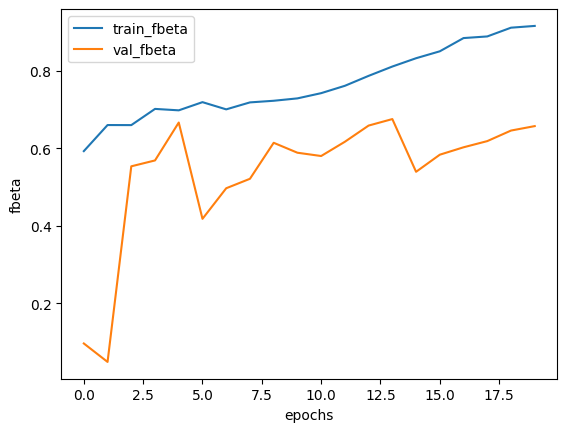

In [34]:
plt.plot(fbetamodel2_128_20.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel2_128_20.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('fbeta')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

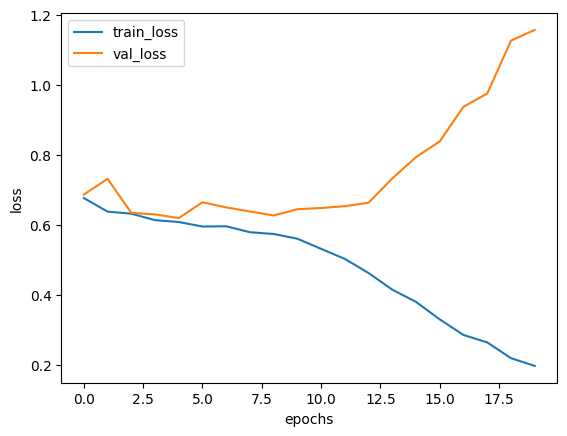

In [35]:
plt.plot(fbetamodel2_128_20.history['loss'],label='train_loss')
plt.plot(fbetamodel2_128_20.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model2' with the following hyperparameters:
### - Epoch number = 20
### - Batch size = 256

In [38]:
K.clear_session() # clear the cache of model parameters

fbetamodel2_256_20 = model2.fit(train_images, binary_labels, batch_size=256, epochs=20,validation_split=0.3)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - fbeta: 0.5835 - loss: 0.6867 - val_fbeta: 0.6574 - val_loss: 0.6509
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - fbeta: 0.6508 - loss: 0.6522 - val_fbeta: 0.1675 - val_loss: 0.7233
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - fbeta: 0.6599 - loss: 0.6396 - val_fbeta: 0.2935 - val_loss: 0.6989
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - fbeta: 0.6950 - loss: 0.6174 - val_fbeta: 0.6914 - val_loss: 0.6255
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - fbeta: 0.7128 - loss: 0.6166 - val_fbeta: 0.6561 - val_loss: 0.6242
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - fbeta: 0.7310 - loss: 0.6069 - val_fbeta: 0.5671 - val_loss: 0.6308
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - fbeta: 0.6890 - loss: 0.5959 - val_fbeta: 0.6606 - val_loss: 0.6201
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - fbeta: 0.7185 - loss: 0.5871 - val_fbeta: 0.6777 - val_loss: 0.6191
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 54

### Plotting the history of the fbetascore for the training and the validation set

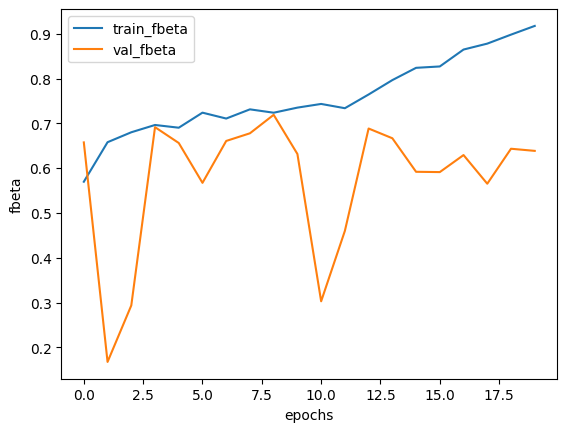

In [39]:
plt.plot(fbetamodel2_256_20.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel2_256_20.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('fbeta')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

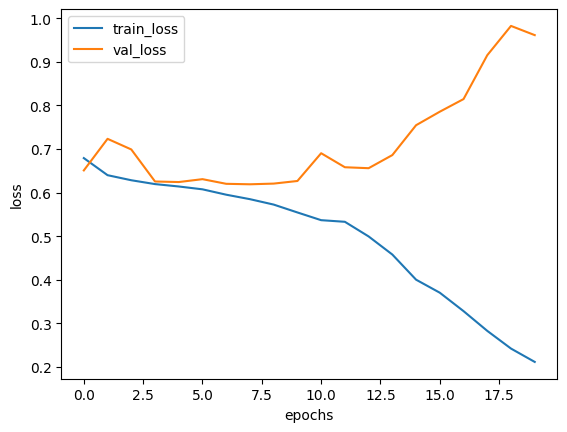

In [40]:
plt.plot(fbetamodel2_256_20.history['loss'],label='train_loss')
plt.plot(fbetamodel2_256_20.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model2' with the following hyperparameters:
### - Epochs number = 20
### - Batch size = 512

In [42]:
K.clear_session() # clear the cache of model parameters

fbetamodel2_512_20 = model2.fit(train_images, binary_labels, batch_size=512, epochs=20,validation_split=0.3)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 69s 7s/step - fbeta: 0.1639 - loss: 0.6931 - val_fbeta: 0.0000e+00 - val_loss: 0.6932
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - fbeta: 0.1324 - loss: 0.6932 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 69s 8s/step - fbeta: 0.8001 - loss: 0.6932 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - fbeta: 0.8269 - loss: 0.6932 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 62s 7s/step - fbeta: 0.8223 - loss: 0.6932 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step - fbeta: 0.7743 - loss: 0.6931 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step - fbeta: 0.5754 - loss: 0.6931 - val_fbeta: 0.0000e+00 - val_loss: 0.6931
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 62s 7s/step - fbeta: 0.4747 - loss: 0.6931 - val_fbeta: 0.0000e+00 - val_loss: 0.6931
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/s

### Plotting the history of the fbetascore for the training and the validation set

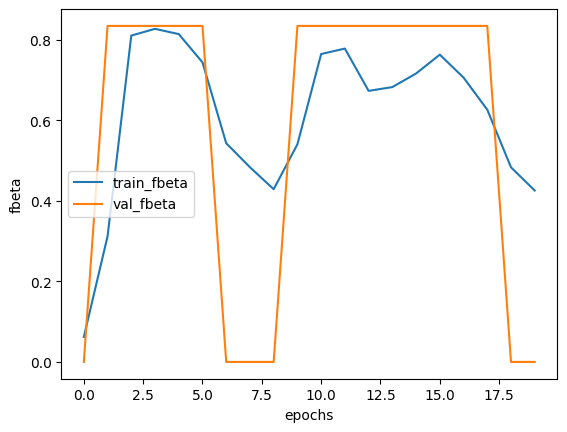

In [43]:
plt.plot(fbetamodel2_512_20.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel2_512_20.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('fbeta')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

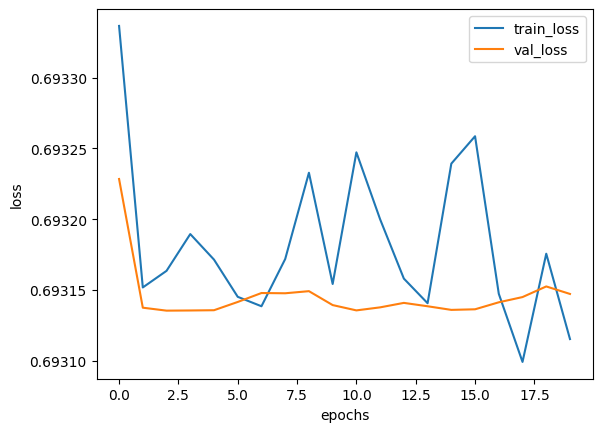

In [44]:
plt.plot(fbetamodel2_512_20.history['loss'],label='train_loss')
plt.plot(fbetamodel2_512_20.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model2' with the following hyperparameters:
### - Epoch number = 100
### - Batch size = 256

In [56]:
K.clear_session() # clear the cache of model parameters

fbetamodel2_256_100 = model2.fit(train_images, binary_labels, batch_size=256, epochs=100,validation_split=0.3)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - fbeta: 0.5356 - loss: 0.6817 - val_fbeta: 0.7629 - val_loss: 0.6613
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - fbeta: 0.7359 - loss: 0.6501 - val_fbeta: 0.2461 - val_loss: 0.6916
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - fbeta: 0.6843 - loss: 0.6278 - val_fbeta: 0.3513 - val_loss: 0.6681
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - fbeta: 0.6958 - loss: 0.6162 - val_fbeta: 0.5932 - val_loss: 0.6309
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - fbeta: 0.7152 - loss: 0.6020 - val_fbeta: 0.4533 - val_loss: 0.6459
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - fbeta: 0.7124 - loss: 0.5954 - val_fbeta: 0.3932 - val_loss: 0.6626
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - fbeta: 0.7041 - loss: 0.5871 - val_fbeta: 0.4517 - val_loss: 0.6487
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - fbeta: 0.7376 - loss: 0.5790 - val_fbeta: 0.5166 - val_loss: 0.6348
Epoch 9/100
18/18 ━━━━━━━━━━━━━━

### Plotting the history of the fbetascore for the training and the validation set

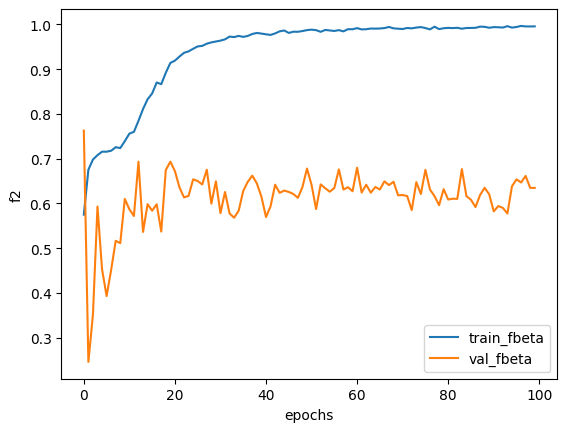

In [58]:
plt.plot(fbetamodel2_256_100.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel2_256_100.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('f2')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

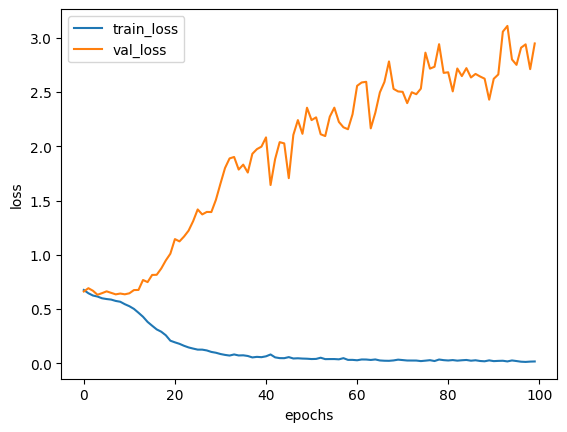

In [59]:
plt.plot(fbetamodel2_256_100.history['loss'],label='train_loss')
plt.plot(fbetamodel2_256_100.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Predictions of "Model2" on test images based on hyperparameters the model learned in the previous training

In [57]:
prediction_model2 = model2.predict(test_images)

print(prediction_model2, binary_labels_2)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
[[9.99976516e-01]
 [1.00000000e+00]
 [6.41985759e-02]
 [1.12934434e-03]
 [2.41258258e-05]
 [8.54420125e-01]
 [1.15388109e-16]
 [1.54526094e-02]
 [9.99996424e-01]
 [9.99964595e-01]
 [9.44220662e-01]
 [2.61459686e-02]
 [9.99989748e-01]
 [6.33511305e-01]
 [9.99994278e-01]
 [9.99978781e-01]
 [6.18463755e-01]
 [2.02659471e-03]
 [9.99997854e-01]
 [8.98825820e-05]
 [1.98441327e-07]
 [9.65655863e-01]
 [1.00000000e+00]
 [9.99998450e-01]
 [9.95832026e-01]
 [1.09626306e-03]
 [9.86953676e-01]
 [2.52872169e-01]
 [9.99999762e-01]
 [9.84977245e-01]
 [9.99721944e-01]
 [1.18995027e-03]
 [9.98226106e-01]
 [9.99986768e-01]
 [2.56070867e-03]
 [9.98895109e-01]
 [5.57382009e-05]
 [2.02592060e-01]
 [9.95422900e-01]
 [9.99990582e-01]
 [9.99999881e-01]
 [9.79543328e-01]
 [6.82486892e-02]
 [9.99998689e-01]
 [9.99039531e-01]
 [1.00000000e+00]
 [8.24411690e-01]
 [9.99977469e-01]
 [2.12000236e-02]
 [2.07355199e-03]
 [9.96997952e-01]
 [9.68317389e-01]
 [1.80541232e-01]
 [5.85

### - "Model3" architecture has dropout layers after each convolutional layer and also one dropout layer after the output (Dense) layer
### - The activation function of the output layer is a 'sigmoid'
### - The optimizer is Adam, this time with a set learning rate of 0.001

In [41]:
K.clear_session() # clear the cache of model parameters

# Define the number of classes
# For binary classification, there's only one output neuron
#num_classes=1

# Define the CNN model, this time with dropout layers to prevent overfitting

model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Add dropout layer after the first convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Add dropout layer after the second convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Add dropout layer after the third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Add dropout layer after the fourth convolutional layer
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Add dropout layer before the output layer
    Dense(1, activation='sigmoid')  # Change activation function to 'sigmoid'
])

# Define your desired learning rate
learning_rate = 0.0001

# Create an optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model using the custom optimizer
model3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta])

model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,086,913 (49.92 MB)

 Trainable params: 13,086,913 (49.92 MB)

 Non-trainable params: 0 (0.00 B)

### Training 'Model3' with the following hyperparameters:
### - Epochs number = 100
### - Batch size = 512

In [17]:
K.clear_session() # clear the cache of model parameters

fbetamodel3_512_100 = model3.fit(train_images, binary_labels, batch_size=512, epochs=100,validation_split=0.3)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 68s 7s/step - fbeta: 0.8094 - loss: 0.6928 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - fbeta: 0.8313 - loss: 0.6932 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 62s 7s/step - fbeta: 0.8344 - loss: 0.6931 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step - fbeta: 0.8286 - loss: 0.6932 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 61s 7s/step - fbeta: 0.8385 - loss: 0.6931 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - fbeta: 0.8339 - loss: 0.6931 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step - fbeta: 0.8372 - loss: 0.6931 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step - fbeta: 0.8310 - loss: 0.6932 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 62s 7s/step

### Plotting the history of the fbetascore for the training and the validation set

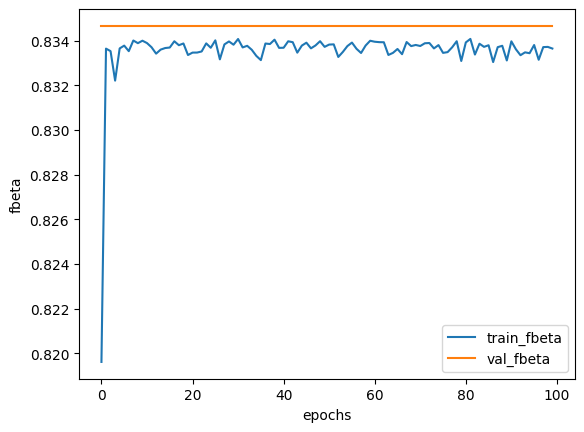

In [18]:
plt.plot(fbetamodel3_512_100.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel3_512_100.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('fbeta')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

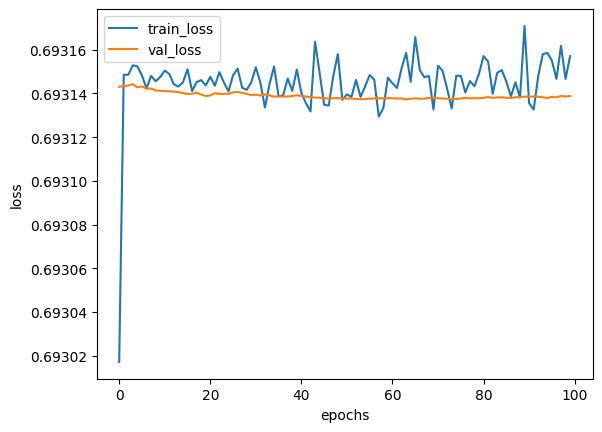

In [19]:
plt.plot(fbetamodel3_512_100.history['loss'],label='train_loss')
plt.plot(fbetamodel3_512_100.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Predictions of "Model3" on test images based on hyperparameters the model learned in the previous training

In [ ]:
# Model3 architecture predictions on test images

prediction_model3 = model3.predict(test_images)

# print predicted probabilities

print(prediction_model3, binary_labels_2)

### Save the output of the predicted probabilities of "Model3" in a .npy file

In [ ]:
np.save('cnn_prediction_model3.npy', prediction_model3)

### - Loading the predicted probabilities
### - Converting the predicted probabilities into binary classifications based on a threshold value set at 0.5 
##### (predicted probabilities above 0.5 will be classified as 1, whereas predicted probabilities below 0.5 will be classified as 0)
### - Generating the confusion matrix and plotting it

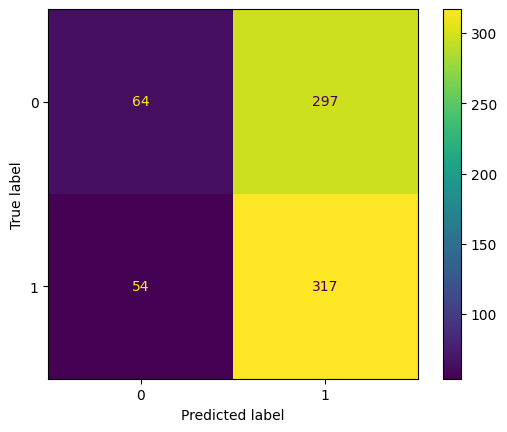

In [31]:
# Load your array from the .npy file
cnn_prediction_model3 = np.load('cnn_prediction_model3.npy')

# Convert predicted probabilities to binary predictions
y_pred_classes = (cnn_prediction_model3 > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(binary_labels_2, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(binary_labels_2))
disp.plot()
plt.show()

### Definition of F2 score with fbeta (function previously shown in this notebook) applied to the labels of the images and the binary classifications, then generation of the classification report that includes it

In [32]:
# Calculate F2 score
f2score = fbeta(binary_labels_2, y_pred_classes)

# Generate classification report with F2 score
report = classification_report(binary_labels_2, y_pred_classes, target_names=['class_0', 'class_1'])
report += f'\nF2 Score: {f2score:.4f}'
print(report)

              precision    recall  f1-score   support

     class_0       0.54      0.18      0.27       361
     class_1       0.52      0.85      0.64       371

    accuracy                           0.52       732
   macro avg       0.53      0.52      0.46       732
weighted avg       0.53      0.52      0.46       732

F2 Score: 0.7555


### - "Model4" architecture has dropout layers after each convolutional layer set at 0.5 and one dropout layer before the output (Dense) layer set at 0.75 
##### (0.5 and 0.75 are the probabilities of dropping neurons or features in the dropout layers - they have been changed compared to the previous model architectures in order to test empirically if the training of this neural network can improve the learning performance on this dataset)

### - The optimizer is still Adam, but this time with a learning rate set at 0.0001

In [84]:
K.clear_session() # clear the cache of model parameters

# Define the number of classes
# For binary classification, there's only one output neuron
#num_classes=1

# Define the CNN model, this time with dropout layers to prevent overfitting

model4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.5),  # Add dropout layer after the first convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.5),  # Add dropout layer after the second convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.5),  # Add dropout layer after the third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.5),  # Add dropout layer after the fourth convolutional layer
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.75),  # Add dropout layer before the output layer
    Dense(1, activation='sigmoid')  # Change activation function to 'sigmoid'
])

# Define your desired learning rate
learning_rate = 0.0001

# Create an optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model using the custom optimizer
model4.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta])

model4.summary()

/Users/marianosantoro/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,086,913 (49.92 MB)

 Trainable params: 13,086,913 (49.92 MB)

 Non-trainable params: 0 (0.00 B)

### Training 'Model4' with the following hyperparameters:
### - Epoch number = 100
### - Batch size = 512

In [85]:
K.clear_session() # clear the cache of model parameters

fbetamodel4_512_100 = model4.fit(train_images, binary_labels, batch_size=512, epochs=100,validation_split=0.3)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 81s 9s/step - fbeta: 0.2128 - loss: 0.6931 - val_fbeta: 0.0000e+00 - val_loss: 0.6931
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 75s 8s/step - fbeta: 0.3083 - loss: 0.6931 - val_fbeta: 0.0000e+00 - val_loss: 0.6931
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 74s 8s/step - fbeta: 0.3232 - loss: 0.6931 - val_fbeta: 0.0000e+00 - val_loss: 0.6931
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 73s 8s/step - fbeta: 0.4408 - loss: 0.6931 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 72s 8s/step - fbeta: 0.5760 - loss: 0.6932 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 75s 8s/step - fbeta: 0.6557 - loss: 0.6932 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 74s 8s/step - fbeta: 0.6785 - loss: 0.6931 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 75s 8s/step - fbeta: 0.6927 - loss: 0.6932 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━

### Plotting the history of the fbetascore for the training and the validation set


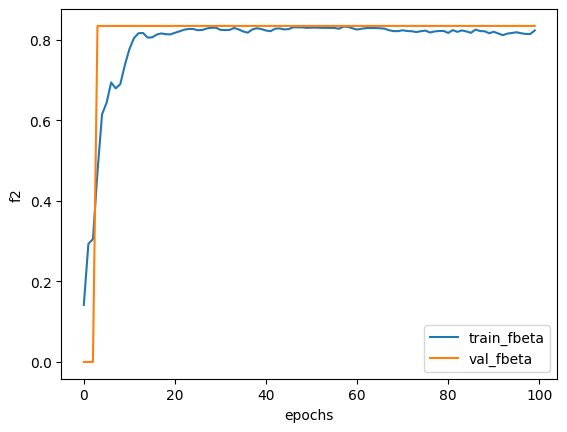

In [86]:
plt.plot(fbetamodel4_512_100.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel4_512_100.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('f2')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

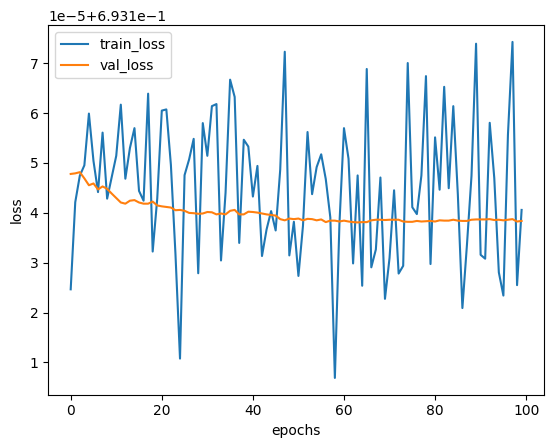

In [87]:
plt.plot(fbetamodel4_512_100.history['loss'],label='train_loss')
plt.plot(fbetamodel4_512_100.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model4' with the following hyperparameters:
### - Epochs number = 100
### - Batch size = 256

In [61]:
K.clear_session() # clear the cache of model parameters

fbetamodel4_256_100 = model4.fit(train_images, binary_labels, batch_size=256, epochs=100,validation_split=0.3)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - fbeta: 0.7662 - loss: 0.6848 - val_fbeta: 0.5657 - val_loss: 0.6896
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - fbeta: 0.7217 - loss: 0.6689 - val_fbeta: 0.0571 - val_loss: 0.6880
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - fbeta: 0.5922 - loss: 0.6534 - val_fbeta: 0.0177 - val_loss: 0.6906
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - fbeta: 0.6342 - loss: 0.6492 - val_fbeta: 0.0081 - val_loss: 0.6941
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - fbeta: 0.6696 - loss: 0.6342 - val_fbeta: 0.0000e+00 - val_loss: 0.7028
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - fbeta: 0.6658 - loss: 0.6340 - val_fbeta: 0.0012 - val_loss: 0.7008
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - fbeta: 0.6685 - loss: 0.6317 - val_fbeta: 0.0000e+00 - val_loss: 0.7144
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - fbeta: 0.6319 - loss: 0.6366 - val_fbeta: 0.0012 - val_loss: 0.7142
Epoch 9/100
18/18 ━━━━━━

### Plotting the history of the fbetascore for the training and the validation set

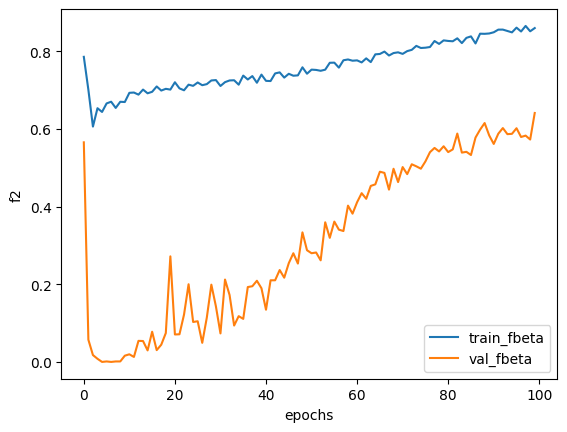

In [62]:
plt.plot(fbetamodel4_256_100.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel4_256_100.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('f2')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

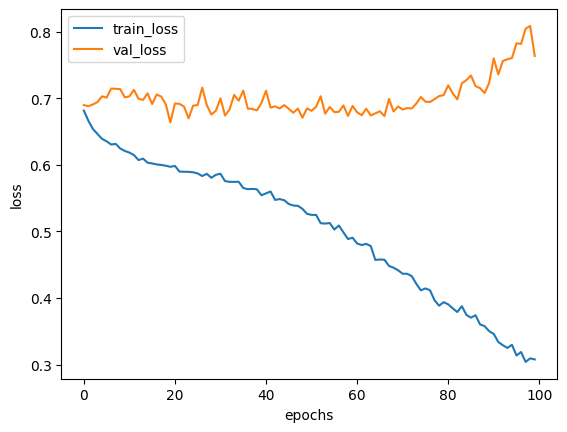

In [63]:
plt.plot(fbetamodel4_256_100.history['loss'],label='train_loss')
plt.plot(fbetamodel4_256_100.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Predictions of 'Model4' on the images of the test set based on hyperparameters learned by the model in the last training 

In [80]:
# Model4 architecture predictions on test images

cnn_prediction_model4 = model4.predict(test_images)

# print the predicted probabilities

print(cnn_prediction_model4)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
[[8.64143491e-01]
 [8.85760605e-01]
 [9.63893011e-02]
 [2.68190056e-01]
 [4.81512934e-01]
 [8.00737083e-01]
 [7.82858301e-03]
 [1.93364561e-01]
 [9.08559978e-01]
 [8.53762865e-01]
 [4.70825046e-01]
 [4.69488531e-01]
 [9.57435429e-01]
 [5.01935542e-01]
 [9.71968412e-01]
 [7.77699649e-01]
 [8.80026162e-01]
 [1.06981143e-01]
 [9.21170950e-01]
 [1.04932226e-01]
 [2.86303181e-02]
 [9.02412772e-01]
 [9.93983686e-01]
 [8.90982866e-01]
 [7.19266832e-01]
 [6.58511579e-01]
 [5.89566290e-01]
 [2.09721744e-01]
 [2.54091352e-01]
 [4.75947499e-01]
 [4.08370256e-01]
 [3.40978950e-01]
 [9.71856773e-01]
 [9.86207724e-01]
 [6.70727968e-01]
 [5.77410519e-01]
 [1.65184624e-02]
 [3.59774709e-01]
 [9.33563888e-01]
 [6.70690417e-01]
 [7.44269669e-01]
 [7.81130433e-01]
 [9.59455550e-01]
 [8.73869956e-01]
 [7.66373873e-01]
 [6.37692630e-01]
 [5.64368606e-01]
 [8.78675699e-01]
 [1.07592531e-01]
 [3.13461900e-01]
 [7.48376489e-01]
 [5.70695341e-01]
 [1.80341348e-01]
 [3.48

### Save the output of the predicted probabilities of the Model4

In [83]:
# Assuming cnn_prediction_model4 is a numpy array

np.save('cnn_prediction_model4.npy', cnn_prediction_model4)

### - Loading the predicted probabilities
### - Converting the predicted probabilities into binary classifications based on a threshold value set at 0.5 
##### (predicted probabilities above 0.5 will be classified as 1, whereas predicted probabilities below 0.5 will be classified as 0)
### - Generating the confusion matrix and plotting it

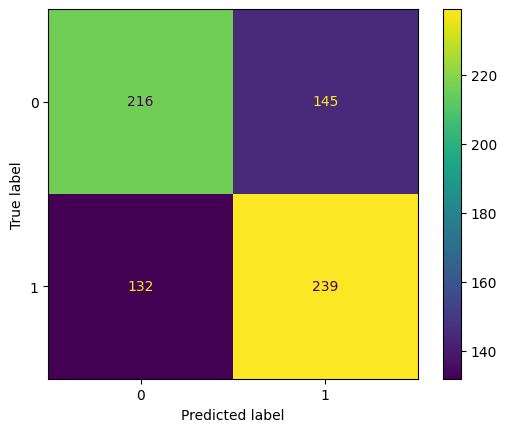

In [55]:
# Load your array from the .npy file
cnn_prediction_model4 = np.load('cnn_prediction_model4.npy')

# Convert predicted probabilities to binary classifications
y_pred_classes = (cnn_prediction_model4 > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(binary_labels_2, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(binary_labels_2))
disp.plot()
plt.show()

### Definition of F2 score with fbeta (function previously shown in this notebook) applied to the labels of the images and the binary classifications, then generation of the classification report that includes it

In [56]:
# Calculate F2 score
f2score = fbeta(binary_labels_2, y_pred_classes)

# Generate classification report with F2 score
report = classification_report(binary_labels_2, y_pred_classes, target_names=['class_0', 'class_1'])
report += f'\nF2 Score: {f2score:.4f}'
print(report)

              precision    recall  f1-score   support

     class_0       0.62      0.60      0.61       361
     class_1       0.62      0.64      0.63       371

    accuracy                           0.62       732
   macro avg       0.62      0.62      0.62       732
weighted avg       0.62      0.62      0.62       732

F2 Score: 0.6397


### - "Model5" architecture has batch normalization layers after each convolutional layers
### - Same dropout layers as for 'Model4' 
### - The optimizer is Adam with a learning rate set at 0.0001

In [22]:
K.clear_session() # clear the cache of model parameters

# Define the number of classes
# For binary classification, there's only one output neuron
#num_classes=1

# Define the CNN model, this time with dropout layers to prevent overfitting

model5 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.5),  # Add dropout layer after the first convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.5),  # Add dropout layer after the second convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.5),  # Add dropout layer after the third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.5),  # Add dropout layer after the fourth convolutional layer
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.75),  # Add dropout layer before the output layer
    Dense(1, activation='sigmoid')  # Change activation function to 'sigmoid'
])

# Define your desired learning rate
learning_rate = 0.0001

# Create an optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model using the custom optimizer
model5.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta])

model5.summary()

/Users/marianosantoro/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,090,369 (49.94 MB)

 Trainable params: 13,088,641 (49.93 MB)

 Non-trainable params: 1,728 (6.75 KB)

### Training 'Model5' with the following hyperparameters:
### - Epoch number = 100
### - Batch size = 256

In [23]:
K.clear_session() # clear the cache of model parameters

fbetamodel5_256_100 = model5.fit(train_images, binary_labels, batch_size=256, epochs=100,validation_split=0.3)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 159s 9s/step - fbeta: 0.5360 - loss: 1.1856 - val_fbeta: 0.0000e+00 - val_loss: 0.8089
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 155s 9s/step - fbeta: 0.5667 - loss: 1.0816 - val_fbeta: 0.0000e+00 - val_loss: 0.8634
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 154s 9s/step - fbeta: 0.5624 - loss: 1.0668 - val_fbeta: 0.0000e+00 - val_loss: 0.8984
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 154s 9s/step - fbeta: 0.5545 - loss: 1.0013 - val_fbeta: 0.0000e+00 - val_loss: 0.9287
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 154s 8s/step - fbeta: 0.5896 - loss: 0.9701 - val_fbeta: 0.0000e+00 - val_loss: 0.9698
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 154s 9s/step - fbeta: 0.5771 - loss: 0.9881 - val_fbeta: 0.0000e+00 - val_loss: 0.9557
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 161s 9s/step - fbeta: 0.5704 - loss: 0.9563 - val_fbeta: 0.0000e+00 - val_loss: 1.1832
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 148s 8s/step - fbeta: 0.5251 - loss: 0.9238 - val_fbeta: 0.0000e+00 - val_loss:

### Plotting the history of the fbetascore for the training and the validation set

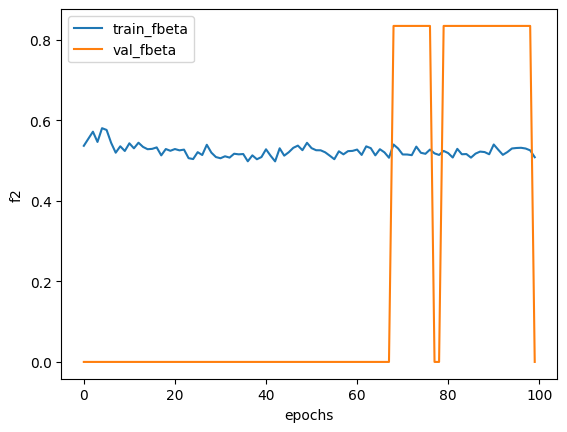

In [25]:
plt.plot(fbetamodel5_256_100.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel5_256_100.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('f2')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

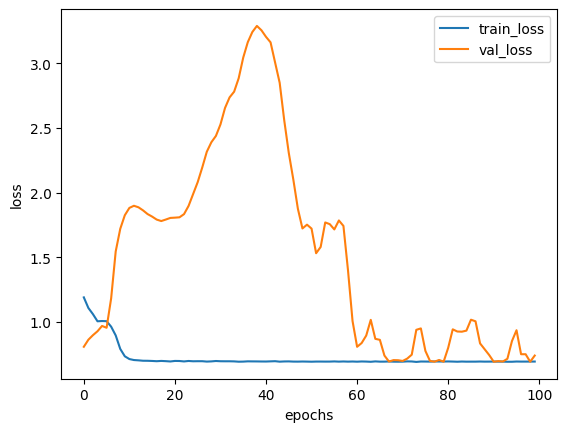

In [26]:
plt.plot(fbetamodel5_256_100.history['loss'],label='train_loss')
plt.plot(fbetamodel5_256_100.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model5' with the following hyperparameters:
### - Epochs number = 100
### - Batch size = 512

In [36]:
K.clear_session() # clear the cache of model parameters

fbetamodel5_512_100 = model5.fit(train_images, binary_labels, batch_size=512, epochs=100,validation_split=0.3)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 318s 35s/step - fbeta: 0.5046 - loss: 1.2614 - val_fbeta: 0.0000e+00 - val_loss: 0.6944
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 181s 20s/step - fbeta: 0.5144 - loss: 1.2205 - val_fbeta: 0.0000e+00 - val_loss: 0.6990
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 183s 20s/step - fbeta: 0.4853 - loss: 1.1934 - val_fbeta: 0.0000e+00 - val_loss: 0.7068
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 184s 20s/step - fbeta: 0.4929 - loss: 1.1491 - val_fbeta: 0.0000e+00 - val_loss: 0.7175
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 182s 20s/step - fbeta: 0.4996 - loss: 1.1310 - val_fbeta: 0.0000e+00 - val_loss: 0.7275
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 181s 20s/step - fbeta: 0.4933 - loss: 1.1313 - val_fbeta: 0.0000e+00 - val_loss: 0.7387
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 183s 20s/step - fbeta: 0.4944 - loss: 1.1039 - val_fbeta: 0.0000e+00 - val_loss: 0.7517
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 181s 20s/step - fbeta: 0.4938 - loss: 1.0901 - val_fbeta: 0.0000e+00 - val_loss: 0.7682


### Plotting the history of the fbetascore for the training and the validation set

In [24]:
plt.plot(fbetamodel5_512_100.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel5_512_100.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('fbeta')
plt.legend()

NameError: name 'fbetamodel5_512_100' is not defined

### Plotting the history of the loss function of the train set and the validation set

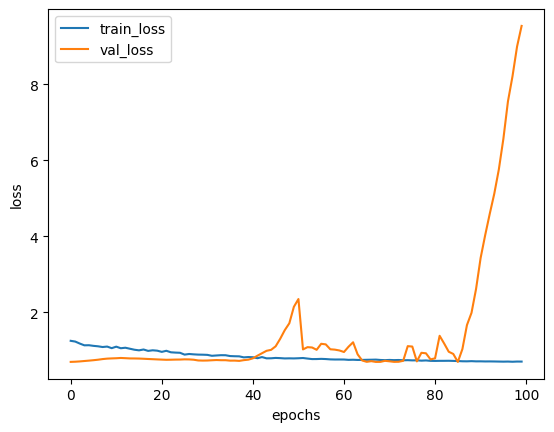

In [38]:
plt.plot(fbetamodel5_512_100.history['loss'],label='train_loss')
plt.plot(fbetamodel5_512_100.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Predictions of 'Model5' on the images of the test set based on hyperparameters learned by the model in the last training 

In [93]:
# Model5 architecture predictions on test images

prediction_model5 = model5.predict(test_images)

# print the predicted probabilities

print(prediction_model5, binary_labels_2)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step
[[0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.35115805]
 [0.351

### No output saved in a .npy file given that the results of the predicted probabilities

In [17]:
K.clear_session() # clear the cache of model parameters

fbetamodel5_512_50 = model5.fit(train_images, binary_labels, batch_size=512, epochs=50,validation_split=0.3)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 296s 33s/step - fbeta: 0.4905 - loss: 1.3134 - val_fbeta: 0.0000e+00 - val_loss: 0.6937
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 184s 20s/step - fbeta: 0.5149 - loss: 1.2738 - val_fbeta: 0.0000e+00 - val_loss: 0.6993
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 183s 20s/step - fbeta: 0.5192 - loss: 1.2646 - val_fbeta: 0.0000e+00 - val_loss: 0.7182
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 180s 20s/step - fbeta: 0.5037 - loss: 1.2050 - val_fbeta: 0.0000e+00 - val_loss: 0.7560
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 183s 20s/step - fbeta: 0.4964 - loss: 1.1964 - val_fbeta: 0.0000e+00 - val_loss: 0.8100
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 181s 20s/step - fbeta: 0.5031 - loss: 1.1646 - val_fbeta: 0.0000e+00 - val_loss: 0.8806
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 182s 20s/step - fbeta: 0.4950 - loss: 1.1125 - val_fbeta: 0.0000e+00 - val_loss: 0.9662
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 181s 20s/step - fbeta: 0.4633 - loss: 1.1842 - val_fbeta: 0.0000e+00 - val_loss: 1.0656
Epoch 9/

### Plotting the history of the fbetascore for the training and the validation set

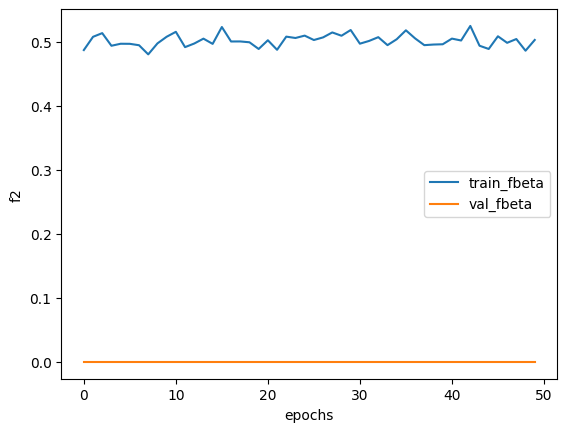

In [20]:
plt.plot(fbetamodel5_512_50.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel5_512_50.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('f2')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

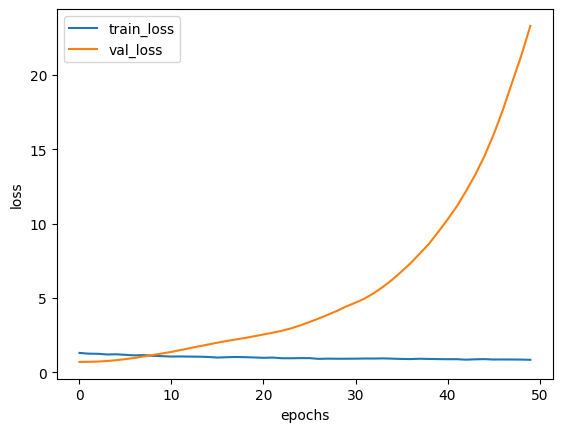

In [19]:
plt.plot(fbetamodel5_512_50.history['loss'],label='train_loss')
plt.plot(fbetamodel5_512_50.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### - "Model6" architecture has ONLY batch normalization layers after each convolutional layers
### - No dropout layers after the convolutional layers, except before the last output (Dense) layer where the dropping probability is set to 0.75 as for the previous model architecture
### - The optimizer is Adam with a learning rate set at 0.0001

In [117]:
K.clear_session() # clear the cache of model parameters

# Define the CNN model, this time with dropout layers to prevent overfitting

model6 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.75),  # Add dropout layer before the output layer
    Dense(1, activation='sigmoid')  # Change activation function to 'sigmoid'
])

# Define your desired learning rate
learning_rate = 0.0001

# Create an optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model using the custom optimizer
model6.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta])

model6.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,090,369 (49.94 MB)

 Trainable params: 13,088,641 (49.93 MB)

 Non-trainable params: 1,728 (6.75 KB)

### Training 'Model6' with the following hyperparameters:
### - Epoch number = 5
### - Batch size = 32

In [118]:
K.clear_session() # clear the cache of model parameters

fbetamodel6_32_100 = model6.fit(train_images, binary_labels, batch_size=32, epochs=5,validation_split=0.3)

Epoch 1/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 108s 724ms/step - fbeta: 0.6019 - loss: 1.1742 - val_fbeta: 0.0000e+00 - val_loss: 0.9031
Epoch 2/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 104s 732ms/step - fbeta: 0.6280 - loss: 0.9377 - val_fbeta: 0.0000e+00 - val_loss: 0.8830
Epoch 3/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 104s 732ms/step - fbeta: 0.6577 - loss: 0.8843 - val_fbeta: 0.0000e+00 - val_loss: 0.8000
Epoch 4/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 104s 735ms/step - fbeta: 0.7016 - loss: 0.7461 - val_fbeta: 0.5976 - val_loss: 0.6462
Epoch 5/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 105s 737ms/step - fbeta: 0.6978 - loss: 0.7317 - val_fbeta: 0.6799 - val_loss: 0.6720


### Plotting the history of the fbetascore for the training and the validation set

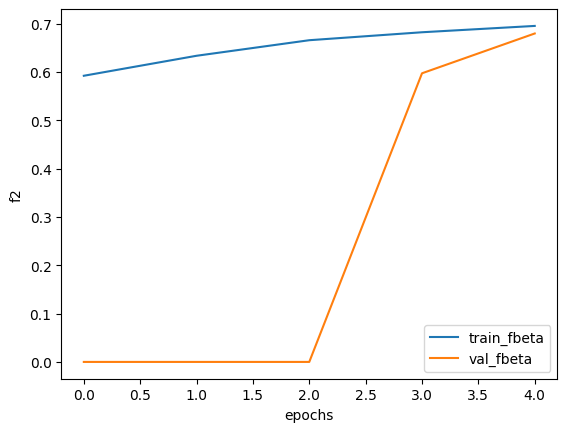

In [119]:
plt.plot(fbetamodel6_32_100.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel6_32_100.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('f2')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

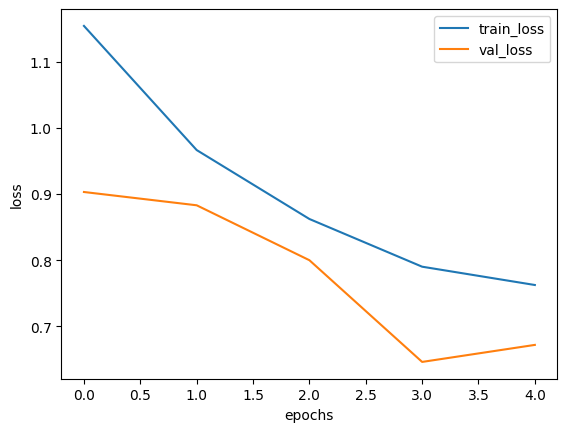

In [120]:
plt.plot(fbetamodel6_32_100.history['loss'],label='train_loss')
plt.plot(fbetamodel6_32_100.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Predictions of 'Model6' on the images of the test set based on hyperparameters learned by the model in the last training

In [54]:
# Model6 architecture predictions on test images

prediction_model6 = model6.predict(test_images)

# print the predicted probabilities

print(prediction_model6, binary_labels_2)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step
[[0.4988683 ]
 [0.5007818 ]
 [0.49986687]
 [0.49986747]
 [0.50063646]
 [0.4998188 ]
 [0.49966395]
 [0.50055015]
 [0.498384  ]
 [0.4997281 ]
 [0.4997735 ]
 [0.50046957]
 [0.49925065]
 [0.5003568 ]
 [0.49979648]
 [0.49984497]
 [0.49988702]
 [0.50035393]
 [0.49919456]
 [0.5000552 ]
 [0.5005718 ]
 [0.5000949 ]
 [0.500857  ]
 [0.5008265 ]
 [0.4998229 ]
 [0.49986306]
 [0.49910706]
 [0.49979582]
 [0.5003182 ]
 [0.5001503 ]
 [0.49833882]
 [0.49961168]
 [0.4996963 ]
 [0.5011407 ]
 [0.4987349 ]
 [0.50061554]
 [0.50081354]
 [0.49929944]
 [0.5006381 ]
 [0.49934104]
 [0.50058055]
 [0.49976873]
 [0.49814972]
 [0.49937358]
 [0.50009066]
 [0.49943915]
 [0.49934265]
 [0.5001553 ]
 [0.50001836]
 [0.4999011 ]
 [0.49945605]
 [0.4999287 ]
 [0.49663994]
 [0.4997728 ]
 [0.4999    ]
 [0.49960786]
 [0.49983776]
 [0.49972025]
 [0.499651  ]
 [0.49991032]
 [0.4994238 ]
 [0.49813512]
 [0.5011264 ]
 [0.5004762 ]
 [0.5004291 ]
 [0.4999416 ]
 [0.5009081 ]
 [0.5006    ]
 [0.499

### No saved output as .npy file of the predicted probabilities of the 'Model6' given that they did not look promising

### Training 'Model6' with the following hyperparameters:
### - Epochs number = 100
### - Batch size = 512

In [44]:
K.clear_session() # clear the cache of model parameters

fbetamodel6_512_100 = model6.fit(train_images, binary_labels, batch_size=512, epochs=100,validation_split=0.3)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 343s 38s/step - fbeta: 0.5631 - loss: 1.2252 - val_fbeta: 0.0000e+00 - val_loss: 0.6978
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 384s 43s/step - fbeta: 0.6392 - loss: 0.9272 - val_fbeta: 0.0000e+00 - val_loss: 0.7295
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 390s 45s/step - fbeta: 0.5142 - loss: 0.7306 - val_fbeta: 0.0000e+00 - val_loss: 0.7324
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 413s 46s/step - fbeta: 0.7082 - loss: 0.6948 - val_fbeta: 0.0000e+00 - val_loss: 0.7677
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 425s 47s/step - fbeta: 0.7518 - loss: 0.5854 - val_fbeta: 0.0000e+00 - val_loss: 0.7999
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 417s 46s/step - fbeta: 0.7486 - loss: 0.5612 - val_fbeta: 0.0000e+00 - val_loss: 0.7580
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 422s 47s/step - fbeta: 0.7364 - loss: 0.5178 - val_fbeta: 0.0000e+00 - val_loss: 0.8067
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 415s 46s/step - fbeta: 0.7960 - loss: 0.4624 - val_fbeta: 0.0000e+00 - val_loss: 0.7834


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x2ec1ac070>
    label = <none> 
    device = <AGXG13GDevice: 0x286352e00>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x10f39b200>
        label = <none> 
        device = <AGXG13GDevice: 0x286352e00>
            name = Apple M1 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x36c1914b0>
    label = <none> 
    device = <AGXG13GDevice: 0x286352e00>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x10f39b200>
    

### - 'Model7' architecture has dropout layers (with probabilities of dropping neurons or features set at 0.25 after each convolutional layer and at 0.50 before the final output layer)
### - The optimizer is still Adam, with a learning rate = 0.000001 


In [17]:
K.clear_session() # clear the cache of model parameters

# Define the CNN model, this time with dropout layers to prevent overfitting

model7 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    Dropout(0.25),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.25),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    Dropout(0.25),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    Dropout(0.25),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.50),  # Add dropout layer before the output layer
    Dense(1, activation='sigmoid')  # Change activation function to 'sigmoid'
])

# Define your desired learning rate
learning_rate = 0.000001

# Create an optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model using the custom optimizer
model7.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta])

model7.summary()

/Users/marianosantoro/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,086,913 (49.92 MB)

 Trainable params: 13,086,913 (49.92 MB)

 Non-trainable params: 0 (0.00 B)

### Training 'Model7' with the following hyperparameters:
### - Epoch number = 100
### - Batch size = 32

In [97]:
K.clear_session() # clear the cache of model parameters

fbetamodel7_32_100 = model7.fit(train_images, binary_labels, batch_size=32, epochs=100,validation_split=0.3)

Epoch 1/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 71s 483ms/step - fbeta: 0.7063 - loss: 0.6906 - val_fbeta: 0.8284 - val_loss: 0.6927
Epoch 2/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 81s 570ms/step - fbeta: 0.7707 - loss: 0.6867 - val_fbeta: 0.8286 - val_loss: 0.6925
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 86s 606ms/step - fbeta: 0.7922 - loss: 0.6850 - val_fbeta: 0.8296 - val_loss: 0.6923
Epoch 4/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 87s 611ms/step - fbeta: 0.8111 - loss: 0.6810 - val_fbeta: 0.8254 - val_loss: 0.6920
Epoch 5/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 90s 632ms/step - fbeta: 0.8151 - loss: 0.6811 - val_fbeta: 0.8235 - val_loss: 0.6918
Epoch 6/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 92s 651ms/step - fbeta: 0.8175 - loss: 0.6787 - val_fbeta: 0.8178 - val_loss: 0.6916
Epoch 7/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 93s 658ms/step - fbeta: 0.8121 - loss: 0.6783 - val_fbeta: 0.8112 - val_loss: 0.6914
Epoch 8/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 94s 662ms/step - fbeta: 0.8098 - loss: 0.6770 - val_fbeta: 0.7955 - val_loss:

### Plotting the history of the fbetascore for the training and the validation set

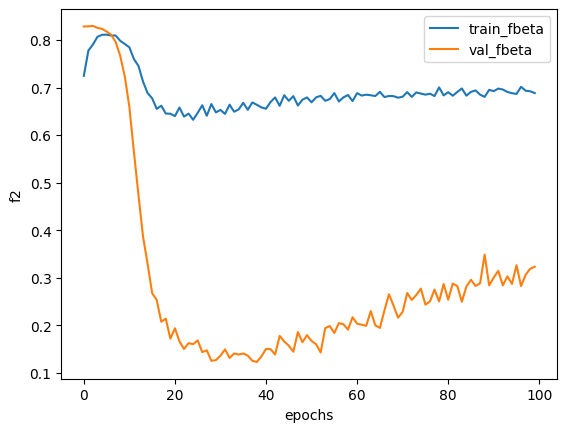

In [98]:
plt.plot(fbetamodel7_32_100.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel7_32_100.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('f2')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

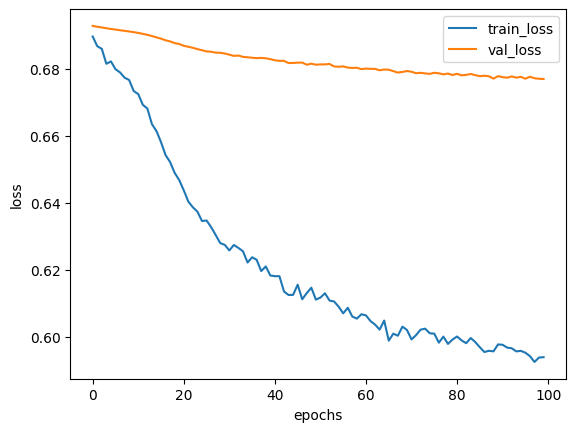

In [99]:
plt.plot(fbetamodel7_32_100.history['loss'],label='train_loss')
plt.plot(fbetamodel7_32_100.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model7' with the following hyperparameters:
### - Epochs number = 100
### - Batch size = 256

In [18]:
K.clear_session() # clear the cache of model parameters

fbetamodel7_256_100 = model7.fit(train_images, binary_labels, batch_size=256, epochs=100,validation_split=0.3)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - fbeta: 0.3586 - loss: 0.6938 - val_fbeta: 0.5213 - val_loss: 0.6931
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - fbeta: 0.5149 - loss: 0.6930 - val_fbeta: 0.7279 - val_loss: 0.6928
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - fbeta: 0.6540 - loss: 0.6924 - val_fbeta: 0.7960 - val_loss: 0.6926
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - fbeta: 0.7498 - loss: 0.6917 - val_fbeta: 0.8145 - val_loss: 0.6923
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - fbeta: 0.7810 - loss: 0.6905 - val_fbeta: 0.8234 - val_loss: 0.6920
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - fbeta: 0.8045 - loss: 0.6900 - val_fbeta: 0.8244 - val_loss: 0.6918
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - fbeta: 0.8138 - loss: 0.6895 - val_fbeta: 0.8298 - val_loss: 0.6915
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - fbeta: 0.8205 - loss: 0.6885 - val_fbeta: 0.8302 - val_loss: 0.6912
Epoch 9/100
18/18 ━━━━━━━━━━━━━━

### Plotting the history of the fbetascore for the training and the validation set

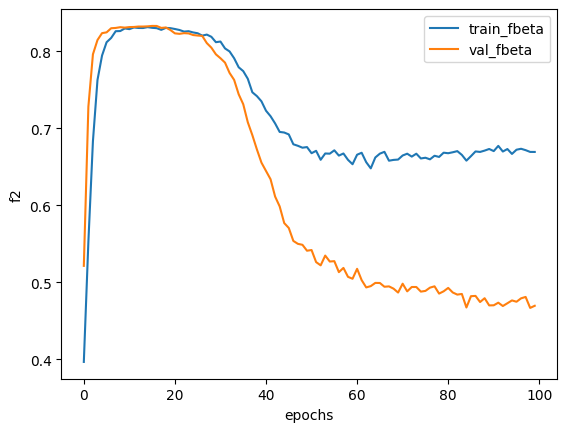

In [19]:
plt.plot(fbetamodel7_256_100.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel7_256_100.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('f2')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

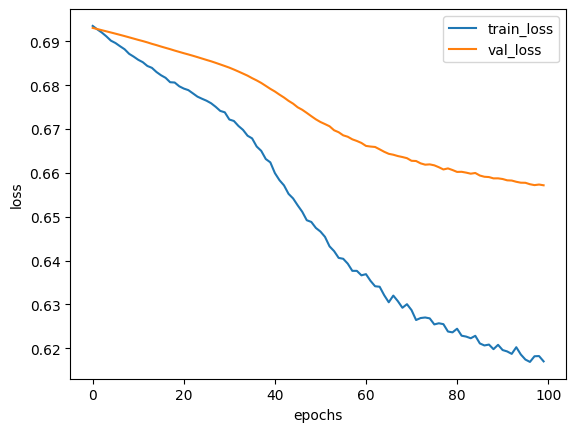

In [20]:
plt.plot(fbetamodel7_256_100.history['loss'],label='train_loss')
plt.plot(fbetamodel7_256_100.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Predictions of 'Model7' on the images of the test set based on hyperparameters learned by the model in the last training

In [21]:
# Model7 architecture predictions on test images

cnn_prediction_model7 = model7.predict(test_images)

# print the predicted probabilities

print(cnn_prediction_model7)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
[[0.530584  ]
 [0.47921294]
 [0.38266742]
 [0.49722716]
 [0.50855154]
 [0.4626626 ]
 [0.45301455]
 [0.46815673]
 [0.5448921 ]
 [0.50542283]
 [0.45888624]
 [0.47657943]
 [0.71891344]
 [0.509951  ]
 [0.5246846 ]
 [0.54334164]
 [0.48443538]
 [0.44688016]
 [0.47269905]
 [0.49803025]
 [0.40308282]
 [0.58173114]
 [0.44578087]
 [0.48690128]
 [0.50492114]
 [0.4702242 ]
 [0.45309347]
 [0.46513957]
 [0.3909708 ]
 [0.4952838 ]
 [0.42391017]
 [0.4554177 ]
 [0.5710345 ]
 [0.5114995 ]
 [0.56273234]
 [0.5183469 ]
 [0.41707954]
 [0.45397186]
 [0.5434867 ]
 [0.4651023 ]
 [0.4356633 ]
 [0.57678914]
 [0.5690689 ]
 [0.5669605 ]
 [0.44466314]
 [0.5206521 ]
 [0.47798952]
 [0.54552996]
 [0.4375434 ]
 [0.3883077 ]
 [0.49283293]
 [0.45753002]
 [0.5832729 ]
 [0.37825206]
 [0.42772904]
 [0.4106878 ]
 [0.38616124]
 [0.5561846 ]
 [0.50223255]
 [0.5539462 ]
 [0.5760174 ]
 [0.55745965]
 [0.54109395]
 [0.51221085]
 [0.51175684]
 [0.49596694]
 [0.541399  ]
 [0.5011901 ]
 [0.4412

### Save the output of predicted probabilities of 'Model7' in a .npy file 

In [22]:
# Assuming cnn_prediction_model7 is a numpy array
np.save('cnn_prediction_model7.npy', cnn_prediction_model7)

### - Loading the predicted probabilities
### - Converting the predicted probabilities into binary classifications based on a threshold value set at 0.5 
##### (predicted probabilities above 0.5 will be classified as 1, whereas predicted probabilities below 0.5 will be classified as 0)
### - Generating the confusion matrix and plotting it

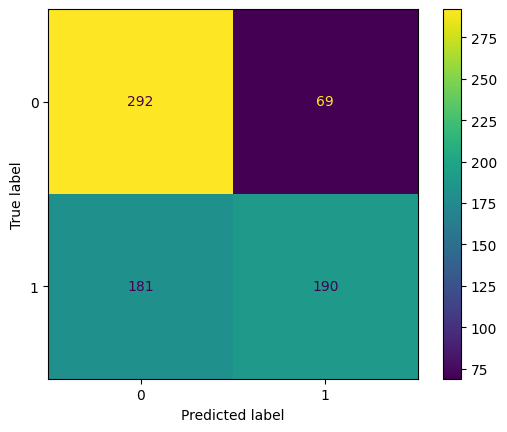

In [23]:
# Assuming cnn_prediction_model7 contains the predicted probabilities for binary classification
# Assuming binary_labels_2 contains the true labels for the test data

# Assuming cnn_prediction_model7 is a numpy array
cnn_prediction_model7 = np.load('cnn_prediction_model7.npy')

# Convert predicted probabilities to binary predictions
y_pred_classes = (cnn_prediction_model7 > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(binary_labels_2, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(binary_labels_2))
disp.plot()
plt.show()

### Definition of F2 score with fbeta (function previously shown in this notebook) applied to the labels of the images and the binary classifications, then generation of the classification report that includes it

In [59]:
# Calculate F2 score
f2score = fbeta(binary_labels_2, y_pred_classes)

# Generate classification report with F2 score
report = classification_report(binary_labels_2, y_pred_classes, target_names=['class_0', 'class_1'])
report += f'\nF2 Score: {f2score:.4f}'
print(report)

              precision    recall  f1-score   support

     class_0       0.62      0.81      0.70       361
     class_1       0.73      0.51      0.60       371

    accuracy                           0.66       732
   macro avg       0.68      0.66      0.65       732
weighted avg       0.68      0.66      0.65       732

F2 Score: 0.5450


### - 'Model8' architecture is equal to 'Model7' with only one HUGE difference: it contains a LSTM layer before the second last convolutional Dense layer
### - The optimizer is still Adam, with a learning rate = 0.000001 

In [25]:
K.clear_session() # clear the cache of model parameters

# Define the CNN model, this time with dropout layers to prevent overfitting

model8 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    Dropout(0.25),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.25),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    Dropout(0.25),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    Dropout(0.25),
    MaxPooling2D(2, 2),
    Flatten(),
    Reshape((1, 25088)),  # Reshape the output of Flatten to (batch_size, timesteps, features)
    LSTM(128),  # Add LSTM layer
    Dense(512, activation='relu'),
    Dropout(0.50),  # Add dropout layer before the output layer
    Dense(1, activation='sigmoid')  # Change activation function to 'sigmoid'
])

# Define your desired learning rate
learning_rate = 0.000001

# Create an optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model using the custom optimizer
model8.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta])

model8.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 25088)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │    12,911,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,218,497 (50.42 MB)

 Trainable params: 13,218,497 (50.42 MB)

 Non-trainable params: 0 (0.00 B)

### Training 'Model8' with the following hyperparameters:
### - Epoch number = 10
### - Batch size = 32

In [28]:
K.clear_session() # clear the cache of model parameters

fbetamodel8_32_10 = model8.fit(train_images, binary_labels, batch_size=32, epochs=10,validation_split=0.3)

Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 69s 466ms/step - fbeta: 0.5780 - loss: 0.6931 - val_fbeta: 0.8154 - val_loss: 0.6931
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 76s 537ms/step - fbeta: 0.7805 - loss: 0.6928 - val_fbeta: 0.8308 - val_loss: 0.6929
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 80s 560ms/step - fbeta: 0.8227 - loss: 0.6924 - val_fbeta: 0.8303 - val_loss: 0.6928
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 80s 566ms/step - fbeta: 0.8328 - loss: 0.6918 - val_fbeta: 0.8320 - val_loss: 0.6926
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 81s 570ms/step - fbeta: 0.8229 - loss: 0.6915 - val_fbeta: 0.8337 - val_loss: 0.6924
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 80s 567ms/step - fbeta: 0.8266 - loss: 0.6904 - val_fbeta: 0.8321 - val_loss: 0.6921
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 81s 568ms/step - fbeta: 0.8332 - loss: 0.6894 - val_fbeta: 0.8324 - val_loss: 0.6917
Epoch 8/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 580ms/step - fbeta: 0.8289 - loss: 0.6883 - val_fbeta: 0.8332 - val_loss: 0.6911


### Plotting the history of the fbetascore for the training and the validation set

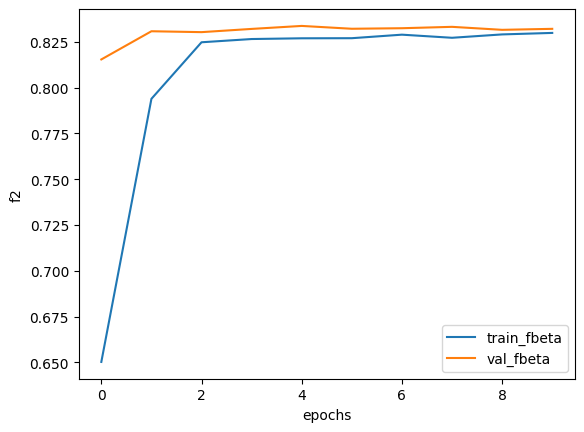

In [29]:
plt.plot(fbetamodel8_32_10.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel8_32_10.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('f2')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

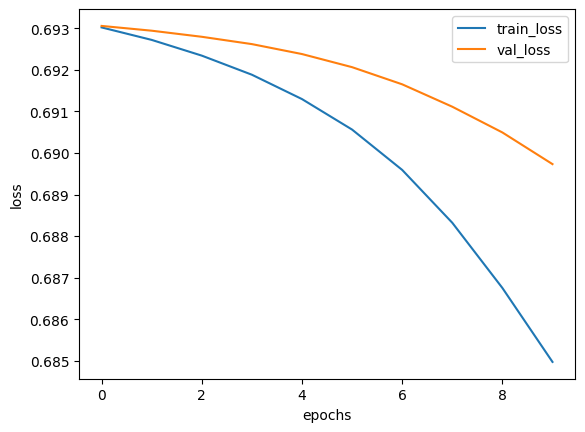

In [30]:
plt.plot(fbetamodel8_32_10.history['loss'],label='train_loss')
plt.plot(fbetamodel8_32_10.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model8' with the following hyperparameters:
### - Epochs number = 10
### - Batch size = 256

In [32]:
K.clear_session() # clear the cache of model parameters

fbetamodel8_256_10 = model8.fit(train_images, binary_labels, batch_size=256, epochs=10,validation_split=0.3)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 94s 5s/step - fbeta: 0.5780 - loss: 0.6931 - val_fbeta: 0.7570 - val_loss: 0.6931
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - fbeta: 0.6878 - loss: 0.6930 - val_fbeta: 0.8025 - val_loss: 0.6931
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step - fbeta: 0.7433 - loss: 0.6930 - val_fbeta: 0.8253 - val_loss: 0.6931
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - fbeta: 0.7756 - loss: 0.6930 - val_fbeta: 0.8305 - val_loss: 0.6931
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 98s 5s/step - fbeta: 0.7980 - loss: 0.6930 - val_fbeta: 0.8327 - val_loss: 0.6931
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step - fbeta: 0.7987 - loss: 0.6930 - val_fbeta: 0.8346 - val_loss: 0.6931
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 110s 6s/step - fbeta: 0.8170 - loss: 0.6929 - val_fbeta: 0.8346 - val_loss: 0.6930
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - fbeta: 0.8153 - loss: 0.6928 - val_fbeta: 0.8368 - val_loss: 0.6930
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━

### Plotting the history of the fbetascore for the training and the validation set

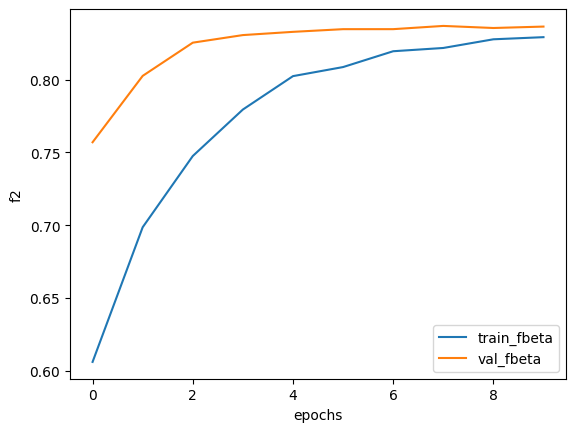

In [33]:
plt.plot(fbetamodel8_256_10.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel8_256_10.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('f2')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

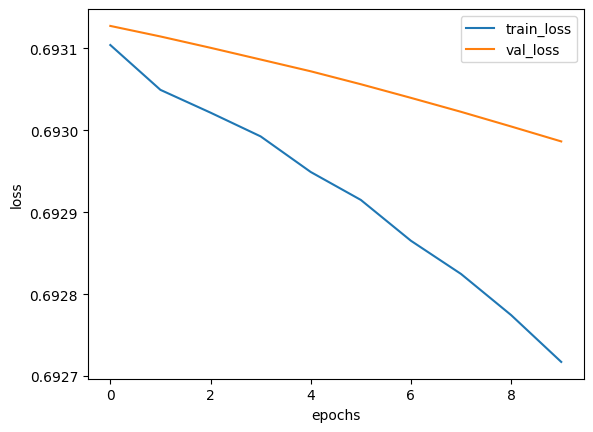

In [34]:
plt.plot(fbetamodel8_256_10.history['loss'],label='train_loss')
plt.plot(fbetamodel8_256_10.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model8' with the following hyperparameters:
### - Epoch number = 20
### - Batch size = 512

In [36]:
K.clear_session() # clear the cache of model parameters

fbetamodel8_512_20 = model8.fit(train_images, binary_labels, batch_size=512, epochs=20,validation_split=0.3)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 113s 12s/step - fbeta: 0.2020 - loss: 0.6933 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 113s 12s/step - fbeta: 0.6770 - loss: 0.6931 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 108s 12s/step - fbeta: 0.8142 - loss: 0.6931 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 96s 11s/step - fbeta: 0.8319 - loss: 0.6931 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 96s 11s/step - fbeta: 0.8269 - loss: 0.6931 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 98s 11s/step - fbeta: 0.8310 - loss: 0.6931 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 99s 11s/step - fbeta: 0.8325 - loss: 0.6931 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 101s 11s/step - fbeta: 0.8274 - loss: 0.6931 - val_fbeta: 0.8347 - val_loss: 0.6931
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 98s 11s/

### Plotting the history of the fbetascore for the training and the validation set

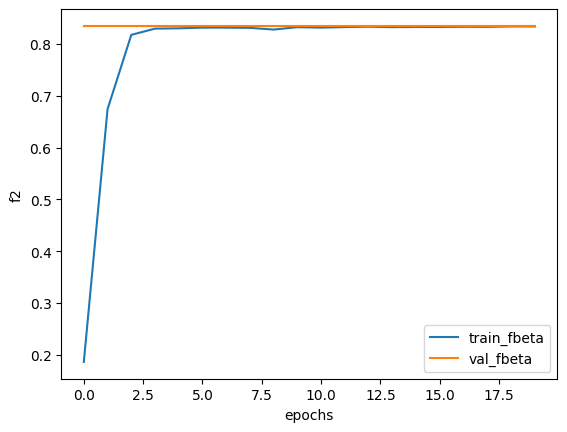

In [37]:
plt.plot(fbetamodel8_512_20.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel8_512_20.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('f2')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

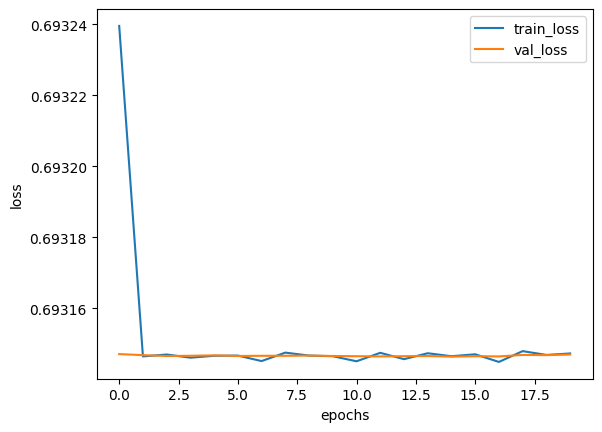

In [38]:
plt.plot(fbetamodel8_512_20.history['loss'],label='train_loss')
plt.plot(fbetamodel8_512_20.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Training 'Model8' with the following hyperparameters:
### - Epochs number = 100
### - Batch size = 256

In [16]:
K.clear_session() # clear the cache of model parameters

fbetamodel8_256_100 = model8.fit(train_images, binary_labels, batch_size=256, epochs=100,validation_split=0.3)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - fbeta: 0.3078 - loss: 0.6932 - val_fbeta: 0.3513 - val_loss: 0.6932
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - fbeta: 0.3999 - loss: 0.6932 - val_fbeta: 0.5985 - val_loss: 0.6931
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - fbeta: 0.5280 - loss: 0.6931 - val_fbeta: 0.7378 - val_loss: 0.6931
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - fbeta: 0.6347 - loss: 0.6931 - val_fbeta: 0.7945 - val_loss: 0.6931
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - fbeta: 0.6939 - loss: 0.6930 - val_fbeta: 0.8061 - val_loss: 0.6931
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - fbeta: 0.7411 - loss: 0.6930 - val_fbeta: 0.8135 - val_loss: 0.6931
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - fbeta: 0.7707 - loss: 0.6930 - val_fbeta: 0.8202 - val_loss: 0.6931
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - fbeta: 0.7871 - loss: 0.6930 - val_fbeta: 0.8217 - val_loss: 0.6931
Epoch 9/100
18/18 ━━━━━━━━━━━━━━

### Plotting the history of the fbetascore for the training and the validation set

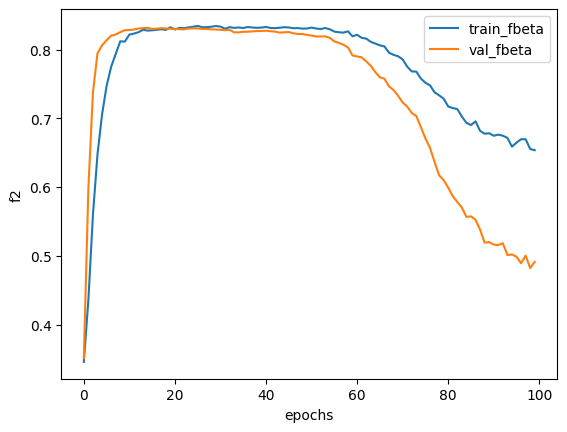

In [17]:
plt.plot(fbetamodel8_256_100.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel8_256_100.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('f2')
plt.legend()

### Plotting the history of the loss function of the train set and the validation set

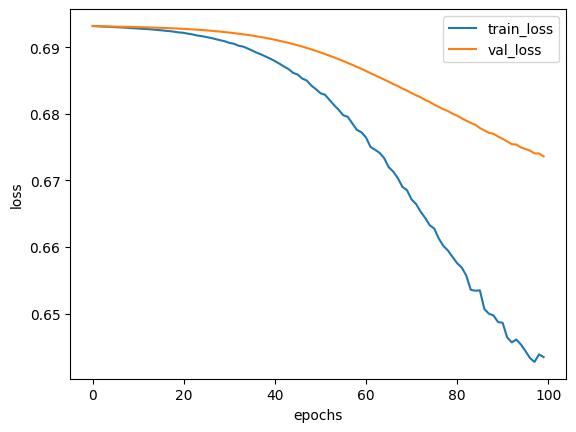

In [18]:
plt.plot(fbetamodel8_256_100.history['loss'],label='train_loss')
plt.plot(fbetamodel8_256_100.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Predictions of 'Model8' on the images of the test set based on hyperparameters learned by the model in the last training

In [19]:
# Model8 architecture predictions on test images

cnn_prediction_model8 = model8.predict(test_images)

# print the prodicted probabilities

print(cnn_prediction_model8)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
[[0.5269451 ]
 [0.47385025]
 [0.45049408]
 [0.5014764 ]
 [0.49623463]
 [0.4830601 ]
 [0.475468  ]
 [0.484132  ]
 [0.5276308 ]
 [0.50805926]
 [0.48638907]
 [0.49889132]
 [0.67164147]
 [0.51716495]
 [0.48630255]
 [0.5342591 ]
 [0.49220267]
 [0.47716388]
 [0.4716237 ]
 [0.48744044]
 [0.45469347]
 [0.55366653]
 [0.46204367]
 [0.4762266 ]
 [0.4908908 ]
 [0.47751737]
 [0.4745631 ]
 [0.46932763]
 [0.45402217]
 [0.49653694]
 [0.43131423]
 [0.48093396]
 [0.534729  ]
 [0.5215635 ]
 [0.5355801 ]
 [0.5037703 ]
 [0.45303696]
 [0.484002  ]
 [0.52856475]
 [0.48747402]
 [0.48097864]
 [0.5484994 ]
 [0.54616565]
 [0.5438071 ]
 [0.4651177 ]
 [0.51869094]
 [0.49596658]
 [0.5296423 ]
 [0.47613373]
 [0.45216262]
 [0.50500536]
 [0.4818063 ]
 [0.5541866 ]
 [0.4495174 ]
 [0.4709219 ]
 [0.46310407]
 [0.45156354]
 [0.53805304]
 [0.49439305]
 [0.5345004 ]
 [0.5514004 ]
 [0.52801204]
 [0.5144483 ]
 [0.5100349 ]
 [0.5220017 ]
 [0.51299083]
 [0.5279534 ]
 [0.5114327 ]
 [0.4746

### Save the output of the predicted probabilities of 'Model8' in a .npy file

In [ ]:
# Assuming second_cnn_prediction_model8 is a numpy array
np.save('cnn_prediction_model8.npy', cnn_prediction_model8)

In [60]:
# Assuming second_cnn_prediction_model8 is a numpy array
cnn_prediction_model8 = np.load('cnn_prediction_model8.npy')

### - Loading the predicted probabilities
### - Converting the predicted probabilities into binary classifications based on a threshold value set at 0.5 
##### (predicted probabilities above 0.5 will be classified as 1, whereas predicted probabilities below 0.5 will be classified as 0)
### - Generating the confusion matrix and plotting it

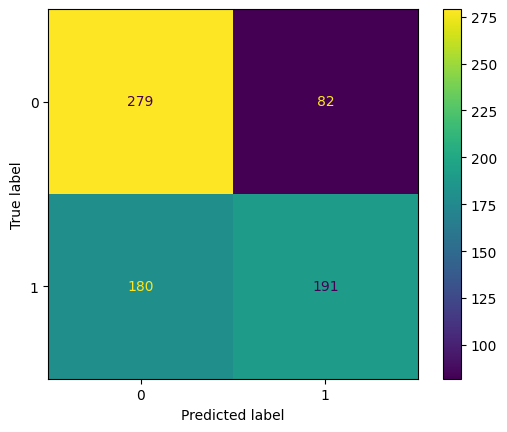

In [61]:
# Assuming binary_labels_2 contains the true labels for the test data

# Assuming second_cnn_prediction_model8 is a numpy array and contains the predicted probabilities for binary classification
cnn_prediction_model8 = np.load('cnn_prediction_model8.npy')

# Convert predicted probabilities to binary predictions
y_pred_classes = (cnn_prediction_model8 > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(binary_labels_2, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(binary_labels_2))
disp.plot()
plt.show()

### Definition of F2 score with fbeta (function previously shown in this notebook) applied to the labels of the images and the binary classifications, then generation of the classification report that includes it

In [62]:
from sklearn.metrics import confusion_matrix, classification_report

# # Generate classification report
# report = classification_report(binary_labels_2, y_pred_classes)
# print(report)

# Calculate F2 score
f2score = fbeta(binary_labels_2, y_pred_classes)

# Generate classification report with F2 score
report = classification_report(binary_labels_2, y_pred_classes, target_names=['class_0', 'class_1'])
report += f'\nF2 Score: {f2score:.4f}'
print(report)

              precision    recall  f1-score   support

     class_0       0.61      0.77      0.68       361
     class_1       0.70      0.51      0.59       371

    accuracy                           0.64       732
   macro avg       0.65      0.64      0.64       732
weighted avg       0.65      0.64      0.64       732

F2 Score: 0.5435


### - 'Model9' architecture is equal to 'Model8' with only a difference: the LSTM layer in this model architecture has number of neurons = 256 (and not = 128 as in 'Model8')) before the second last convolutional Dense layer
### - The optimizer is still Adam, with a learning rate = 0.000001 

In [14]:
K.clear_session() # clear the cache of model parameters

# Define the CNN model, this time with dropout layers to prevent overfitting

model9 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    Dropout(0.25),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.25),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    Dropout(0.25),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    Dropout(0.25),
    MaxPooling2D(2, 2),
    Flatten(),
    Reshape((1, 25088)),  # Reshape the output of Flatten to (batch_size, timesteps, features)
    LSTM(256),  # Add LSTM layer
    Dense(512, activation='relu'),
    Dropout(0.50),  # Add dropout layer before the output layer
    Dense(1, activation='sigmoid')  # Change activation function to 'sigmoid'
])

# Define your desired learning rate
learning_rate = 0.000001

# Create an optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model using the custom optimizer
model9.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta])

model9.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 25088)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │    25,953,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,326,209 (100.43 MB)

 Trainable params: 26,326,209 (100.43 MB)

 Non-trainable params: 0 (0.00 B)

### Training 'Model9' with the following hyperparameters:
### - Epoch number = 100
### - Batch size = 32

In [15]:
K.clear_session() # clear the cache of model parameters

fbetamodel9_32_100 = model9.fit(train_images, binary_labels, batch_size=32, epochs=50,validation_split=0.3)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 73s 498ms/step - fbeta: 0.5932 - loss: 0.6931 - val_fbeta: 0.8312 - val_loss: 0.6930
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 79s 555ms/step - fbeta: 0.8032 - loss: 0.6927 - val_fbeta: 0.8328 - val_loss: 0.6929
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 79s 555ms/step - fbeta: 0.8230 - loss: 0.6924 - val_fbeta: 0.8335 - val_loss: 0.6927
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 79s 554ms/step - fbeta: 0.8275 - loss: 0.6918 - val_fbeta: 0.8326 - val_loss: 0.6925
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 79s 555ms/step - fbeta: 0.8159 - loss: 0.6915 - val_fbeta: 0.8324 - val_loss: 0.6922
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 79s 555ms/step - fbeta: 0.8346 - loss: 0.6896 - val_fbeta: 0.8324 - val_loss: 0.6917
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 79s 554ms/step - fbeta: 0.8278 - loss: 0.6893 - val_fbeta: 0.8335 - val_loss: 0.6912
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 79s 555ms/step - fbeta: 0.8300 - loss: 0.6873 - val_fbeta: 0.8344 - val_loss: 0.6905


### Plotting the history of the fbetascore for the training and the validation set

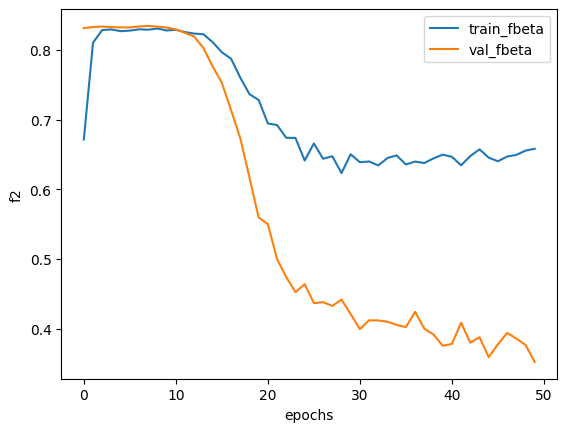

In [16]:
plt.plot(fbetamodel9_32_100.history['fbeta'],label='train_fbeta')
plt.plot(fbetamodel9_32_100.history['val_fbeta'],label='val_fbeta')
plt.xlabel('epochs')
plt.ylabel('f2')
plt.legend()

### Plotting the history of the fbetascore for the training and the validation set

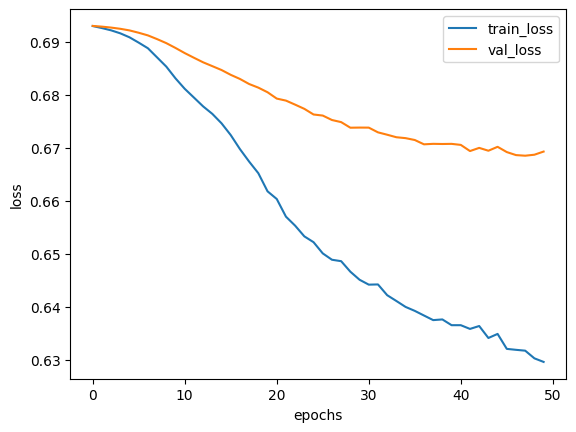

In [17]:
plt.plot(fbetamodel9_32_100.history['loss'],label='train_loss')
plt.plot(fbetamodel9_32_100.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Predictions of 'Model9' on the images of the test set based on hyperparameters learned by the model in the last training

In [18]:
# Model9 architecture predictions on test images

cnn_prediction_model9 = model9.predict(test_images)

# print the predicted probabilities

print(cnn_prediction_model9)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
[[0.52204305]
 [0.46388876]
 [0.40869832]
 [0.48781505]
 [0.48951483]
 [0.4556311 ]
 [0.44843897]
 [0.46987864]
 [0.51382226]
 [0.4787158 ]
 [0.46008286]
 [0.4748405 ]
 [0.70066595]
 [0.49781188]
 [0.4915392 ]
 [0.516114  ]
 [0.46985886]
 [0.448382  ]
 [0.44583488]
 [0.48556393]
 [0.41961357]
 [0.5636759 ]
 [0.4379809 ]
 [0.46449825]
 [0.47816363]
 [0.45815694]
 [0.4564002 ]
 [0.4567504 ]
 [0.4152524 ]
 [0.48008522]
 [0.41627496]
 [0.45379975]
 [0.5314521 ]
 [0.4812611 ]
 [0.5296673 ]
 [0.5025605 ]
 [0.4267515 ]
 [0.4538051 ]
 [0.5153356 ]
 [0.46469143]
 [0.44278613]
 [0.5446852 ]
 [0.540657  ]
 [0.5331388 ]
 [0.44289887]
 [0.5090858 ]
 [0.47183308]
 [0.51021767]
 [0.4369277 ]
 [0.412085  ]
 [0.48534653]
 [0.45871374]
 [0.5658733 ]
 [0.4066473 ]
 [0.4385041 ]
 [0.42721534]
 [0.41016942]
 [0.5339138 ]
 [0.48140526]
 [0.5187211 ]
 [0.54203737]
 [0.52510595]
 [0.50865555]
 [0.494801  ]
 [0.48626444]
 [0.48990425]
 [0.51404625]
 [0.49030158]
 [0.4457

### - Loading the predicted probabilities
### - Converting the predicted probabilities into binary classifications based on a threshold value set at 0.5 
##### (predicted probabilities above 0.5 will be classified as 1, whereas predicted probabilities below 0.5 will be classified as 0)
### - Generating the confusion matrix and plotting it

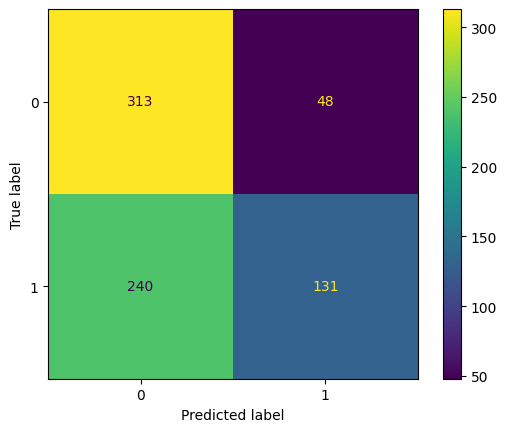

In [30]:
# Assuming cnn_prediction_model9 contains the predicted probabilities for binary classification
# Assuming binary_labels_2 contains the true labels for the test data

# Convert predicted probabilities to binary predictions
y_pred_classes = (cnn_prediction_model9 > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(binary_labels_2, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(binary_labels_2))
disp.plot()
plt.show()

### No output predictied probabilities has been saved as .npy file due to not promising results (the command to be used would eventually be the same as previously shown)